# Fig. 2a


In [1]:
import pandas as pd
import PyComplexHeatmap as pch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
tissues = ["Gastrocnemius", 
           "Heart", 
           "Adrenal", 
           "GonadsFemale",
           "GonadsMale",
           "CortexHippocampus",
           "DiencephalonPituitary",
           "Liver",
           "Kidney"
]

In [3]:
lfc_cutoff = 1
padj_cutoff = 0.01


## Read in data

Old DEG results

In [4]:
merged_all_tissues = []
for tissue in tissues:
    
    df_genes = pd.read_csv(f'/share/crsp/lab/seyedam/share/igvf_pipeline/figures/degs_old_pbulk_strategy/{tissue}/results_de_analysis_celltypes_no_min_cells.csv')
    ct_degs = df_genes[(df_genes['log2FoldChange'] >= lfc_cutoff) & (df_genes['padj'] <= padj_cutoff)]
    ct_degs = ct_degs[['gene_name','subtype', 'tissue']].drop_duplicates()
    ct_degs['celltype_deg'] = "Yes"

    geno_degs_unfilt = pd.read_csv('/share/crsp/lab/seyedam/share/igvf_pipeline/figures/specificity/sig_degs_all_tissues_b6j.csv', index_col = 0)
    geno_degs = geno_degs_unfilt[geno_degs_unfilt['tissue'] == tissue]
    geno_degs.rename(columns={'celltype': 'subtype'}, inplace=True)
    geno_degs = geno_degs[['gene_name', 'subtype', 'genotype', 'tissue']].drop_duplicates()
    geno_degs['genotype_deg'] = "Yes"
    
    merged_df = pd.merge(geno_degs, ct_degs, 
                         on=['gene_name', 'subtype', 'tissue'], how="outer")
    
    merged_all_tissues.append(merged_df)
    
final_merged_df = pd.concat(merged_all_tissues, ignore_index=True)


/tmp/ipykernel_1878618/203303918.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geno_degs.rename(columns={'celltype': 'subtype'}, inplace=True)
/tmp/ipykernel_1878618/203303918.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geno_degs.rename(columns={'celltype': 'subtype'}, inplace=True)
/tmp/ipykernel_1878618/203303918.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geno_degs.rename(columns={'celltype': 'subtype'}, inp

## Start categorizing genes
Since I merged by celltype, if it's both celltype and genotype, it's both in the same celltype.


In [5]:
final_merged_df['DEG_type'] = final_merged_df.apply(
    lambda row: 'both' if row['celltype_deg'] == 'Yes' and row['genotype_deg'] == 'Yes' else
               'celltype' if row['celltype_deg'] == 'Yes' else
               'genotype' if row['genotype_deg'] == 'Yes' else
               'No', axis=1)

In [6]:
# is DE in at LEAST one genotype, at LEAST one celltype
final_merged_df_sub = final_merged_df[['gene_name', 'tissue', 'DEG_type']].drop_duplicates()


In [7]:
all_tissues_df = pd.DataFrame()

for tissue in tissues:
    tissue_df = final_merged_df_sub[final_merged_df_sub['tissue'] == tissue]

    df = tissue_df.copy()

    # Add a new column to classify 'both in same celltype' and 'both in different celltypes'
    df['new_DEG_type'] = df['DEG_type']  # Start by copying the existing DEG_type

    # Identify 'both in same celltype'
    both_same = df[df['DEG_type'] == 'both'].drop_duplicates()
    df = df[~df['gene_name'].isin(both_same['gene_name'])]  # Remove all instances of these genes
    df = pd.concat([df, both_same.assign(new_DEG_type='both (same celltype)')])  # Add them back with the updated label

    # Identify 'both in different celltypes'
    both_different_genes = df.groupby('gene_name')['DEG_type'].apply(lambda x: set(x) == {'genotype', 'celltype'})
    both_different = df[df['gene_name'].isin(both_different_genes[both_different_genes].index)]
    df = df[~df['gene_name'].isin(both_different['gene_name'])].drop_duplicates()  # Remove all instances of these genes
    df = pd.concat([df, both_different.assign(new_DEG_type='both (different celltypes)')])  # Add them back with the updated label

    # Keep only one row per gene_name, now prioritized by the new_DEG_type
    df = df.sort_values(by=['gene_name', 'new_DEG_type']).drop_duplicates(subset='gene_name')

    # Add the tissue column back and combine the results
    df['tissue'] = tissue
    
    #dupes = df['gene_name'].duplicated().sum()
    #print(f'{tissue}: {dupes} duplicated genes')
    all_tissues_df = pd.concat([all_tissues_df, df])

# Reset the index of the combined DataFrame
all_tissues_df.reset_index(drop=True, inplace=True)



## Plot

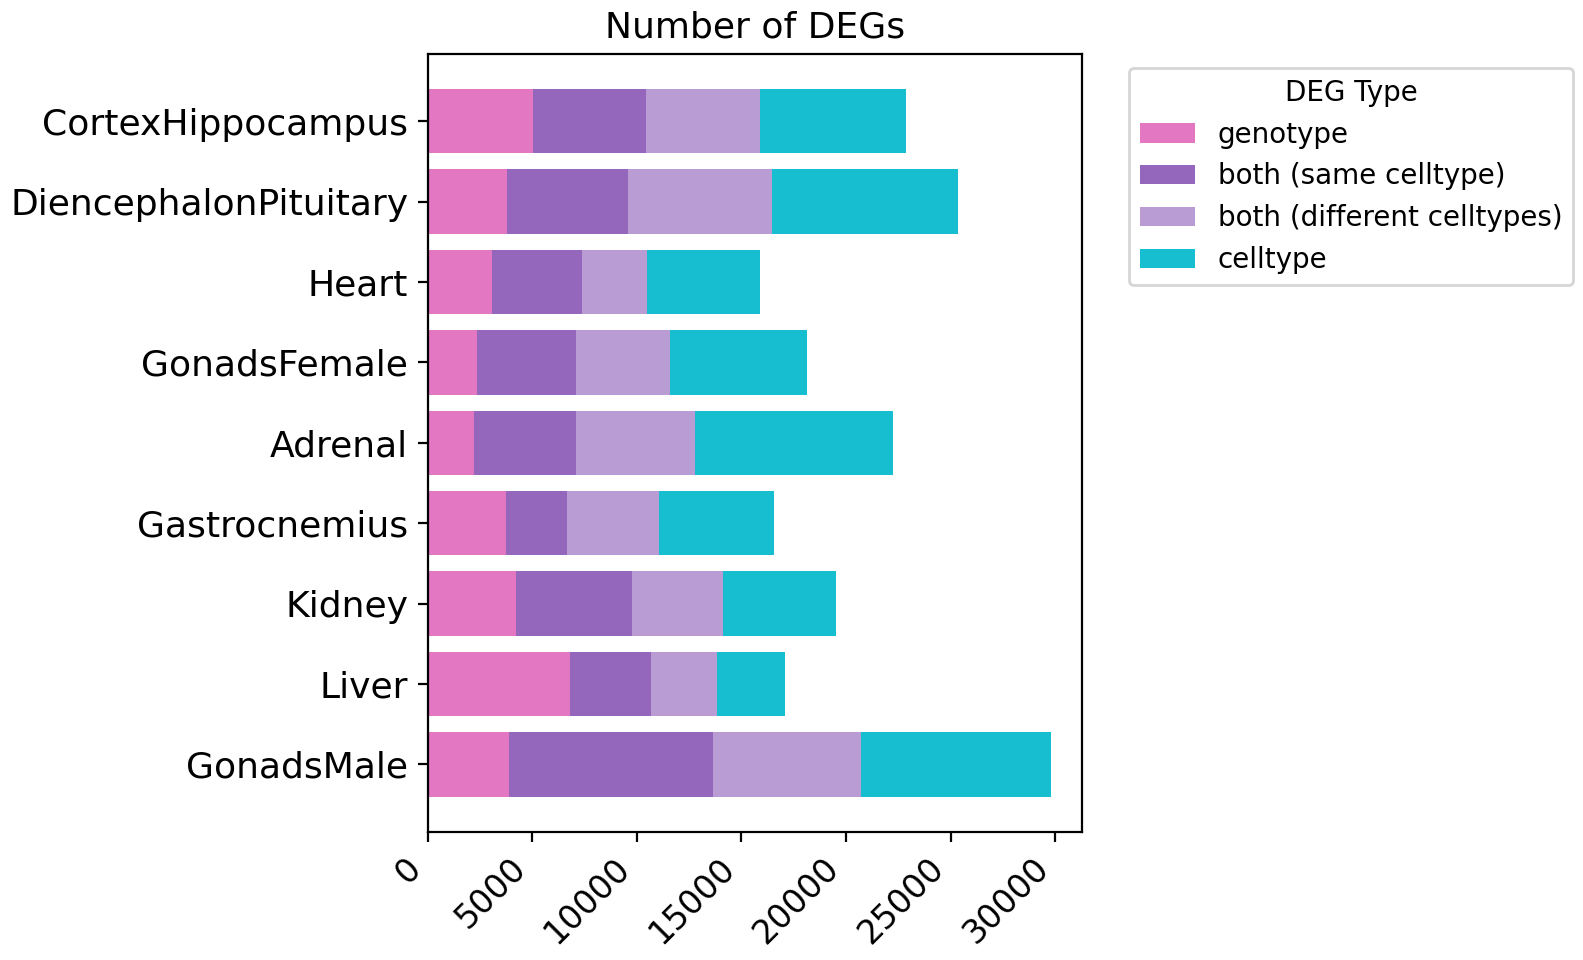

In [8]:
plot_data = all_tissues_df.groupby(['tissue', 'new_DEG_type']).size().unstack(fill_value=0)

tissues = [
    'CortexHippocampus',
    'DiencephalonPituitary',
    'Heart',
    'GonadsFemale',
    'Adrenal',
    'Gastrocnemius',
    'Kidney',
    'Liver',
    'GonadsMale'
][::-1]

desired_order = ['genotype', 'both (same celltype)', 'both (different celltypes)','celltype']
colors = ['#e377c2', '#9467bd', '#ba9cd4', '#17becf']

plot_data = plot_data.loc[tissues, desired_order]

fig, ax = plt.subplots(figsize=(8, 5), dpi=200)
bottoms = [0] * len(plot_data)

plt.xticks(rotation=45, ha='right', fontsize=12)

for i, category in enumerate(plot_data.columns):
    counts = plot_data[category]
    ax.barh(
        plot_data.index,
        counts,
        left=bottoms,
        color=colors[i],
        label=category
    )
    bottoms = [x + y for x, y in zip(bottoms, counts)]

ax.set_ylabel('# Genes')
ax.set_title('Number of DEGs',fontsize=13)
ax.legend(
    title='DEG Type', 
    loc='upper left', 
    bbox_to_anchor=(1.05, 1) 
)
plt.tight_layout()
plt.yticks(fontsize=13)
ax.set_ylabel('')


plt.show()


## Plot version only with both in same celltype

Because I think it's misleading to collapse them...

In [9]:
all_tissues_df_filt = all_tissues_df[all_tissues_df['new_DEG_type'] != 'both (different celltypes)']
all_tissues_df_filt['new_DEG_type'] = all_tissues_df_filt['new_DEG_type'].replace('both (same celltype)', 'both')


/tmp/ipykernel_1878618/1461206043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_tissues_df_filt['new_DEG_type'] = all_tissues_df_filt['new_DEG_type'].replace('both (same celltype)', 'both')


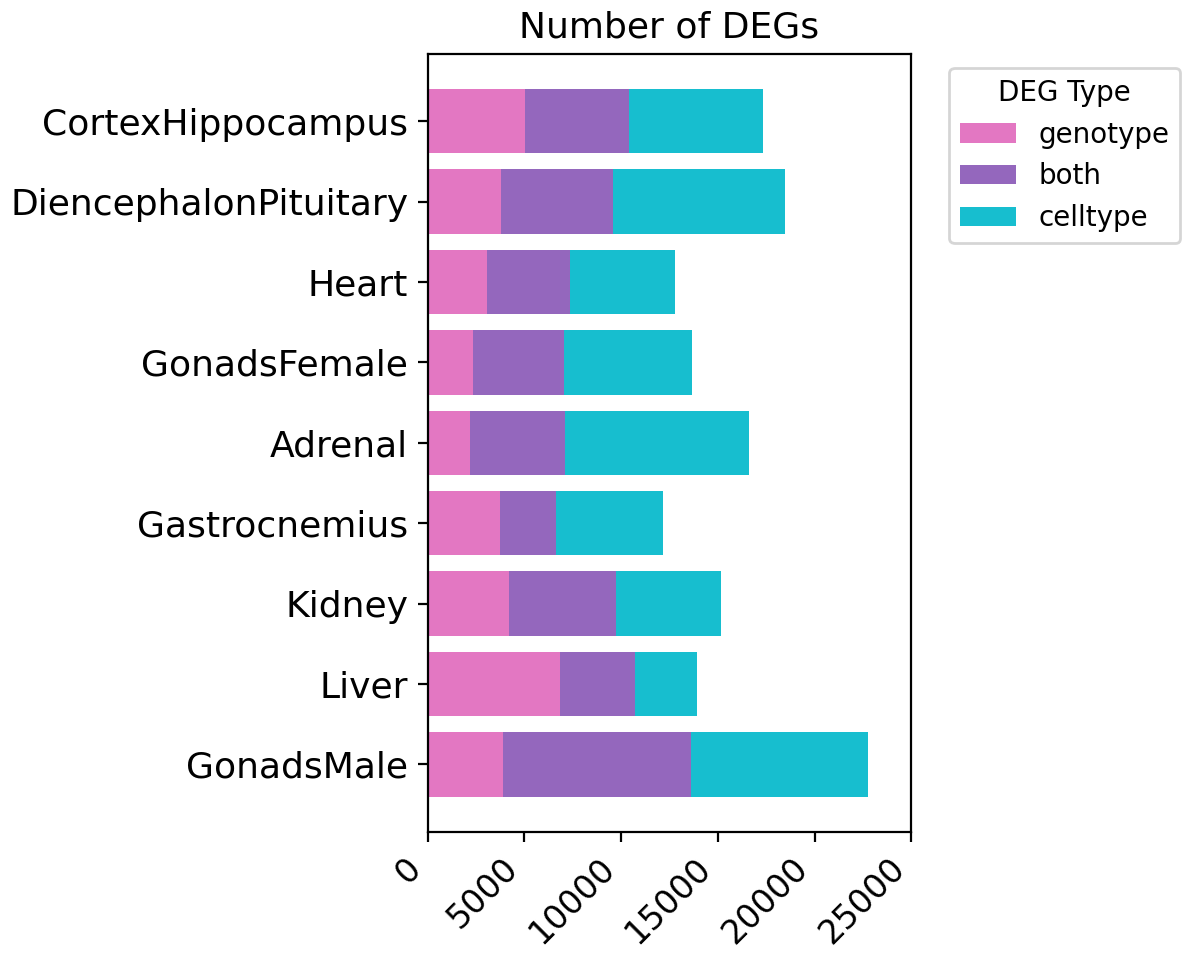

In [10]:
plot_data = all_tissues_df_filt.groupby(['tissue', 'new_DEG_type']).size().unstack(fill_value=0)

tissues = [
    'CortexHippocampus',
    'DiencephalonPituitary',
    'Heart',
    'GonadsFemale',
    'Adrenal',
    'Gastrocnemius',
    'Kidney',
    'Liver',
    'GonadsMale'
][::-1]

desired_order = ['genotype', 'both', 'celltype']
colors = ['#e377c2', '#9467bd', '#17becf']

plot_data = plot_data.loc[tissues, desired_order]

fig, ax = plt.subplots(figsize=(6, 5), dpi=200)
bottoms = [0] * len(plot_data)
plt.xticks(rotation=45, ha='right', fontsize=12)

for i, category in enumerate(plot_data.columns):
    counts = plot_data[category]
    ax.barh(
        plot_data.index,
        counts,
        left=bottoms,
        color=colors[i],
        label=category
    )
    bottoms = [x + y for x, y in zip(bottoms, counts)]

# Add labels and legend
ax.set_ylabel('# Genes')
ax.set_title('Number of DEGs',fontsize=13)
ax.legend(
    title='DEG Type', 
    loc='upper left', 
    bbox_to_anchor=(1.05, 1) 
)
plt.tight_layout()
plt.yticks(fontsize=13)
ax.set_ylabel('')
ax.set_xlim(0, 25000)

plt.savefig('../fig2/deg_type_tissue_barplot.png',bbox_inches='tight', dpi=300)

plt.show()


# Fig. 2b

## Read in celltype degs and geno degs separately

In [11]:
all_tissues = []

for tissue in tissues:
    
    df_genes = pd.read_csv(f'/share/crsp/lab/seyedam/share/igvf_pipeline/figures/degs_old_pbulk_strategy/{tissue}/results_de_analysis_celltypes_no_min_cells.csv')
    ct_degs = df_genes[(df_genes['log2FoldChange'] >= lfc_cutoff) & (df_genes['padj'] <= padj_cutoff)]
    ct_degs = ct_degs[['gene_name','subtype', 'tissue']].drop_duplicates()
  
    all_tissues.append(ct_degs)

ct_degs = pd.concat(all_tissues, ignore_index=True)


In [12]:
geno_degs = pd.read_csv('/share/crsp/lab/seyedam/share/igvf_pipeline/figures/specificity/sig_degs_all_tissues_b6j.csv', index_col = 0)
geno_degs.rename(columns={'celltype': 'subtype'}, inplace=True)
geno_degs = geno_degs[['gene_name', 'subtype', 'genotype', 'tissue']].drop_duplicates()


## Get size of celltypes relative to tissue using metadata file

In [13]:
sizes = pd.read_csv('/share/crsp/lab/seyedam/share/igvf_pipeline/IGVF_analysis/cellbender_tissues/obs_tables/all_tissues_annotated_metadata.csv')
cell_counts = sizes.groupby(['subtype', 'Tissue']).size().reset_index(name='num_cells')
cell_counts = cell_counts.rename(columns={'Tissue': 'tissue'})
total_cells_per_tissue = cell_counts.groupby('tissue')['num_cells'].sum().reset_index(name='total_cells')
cell_counts = cell_counts.merge(total_cells_per_tissue, on='tissue')
cell_counts['percent_cells'] = (cell_counts['num_cells'] / cell_counts['total_cells']) * 100



/tmp/ipykernel_1878618/1999628724.py:1: DtypeWarning: Columns (27,31,33,43,54,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  sizes = pd.read_csv('/share/crsp/lab/seyedam/share/igvf_pipeline/IGVF_analysis/cellbender_tissues/obs_tables/all_tissues_annotated_metadata.csv')


## Merge data

In [14]:
ct_gene_counts = ct_degs[['subtype', 'tissue']].value_counts().reset_index(name='ct_gene_count')
geno_gene_counts = geno_degs[['subtype', 'tissue']].value_counts().reset_index(name='geno_gene_count')
gene_counts = pd.merge(ct_gene_counts, geno_gene_counts, on=['subtype', 'tissue'])
merged_df = pd.merge(gene_counts, cell_counts[['subtype', 'tissue', 'percent_cells']], on=['subtype', 'tissue'], how='left')


## Plot

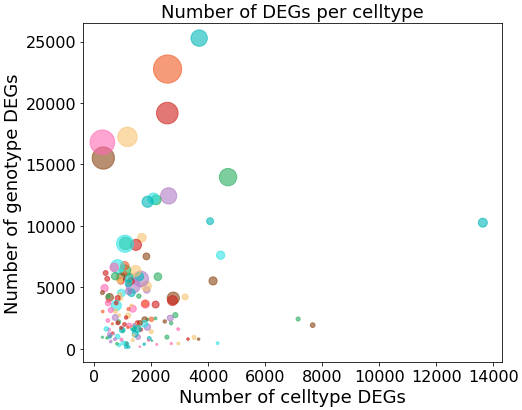

In [15]:
tissue_dict = {
    'CortexHippocampus': '#F8C471',  
    'Heart': '#AF7AC5',             
    'Liver': '#F15922',               
    'DiencephalonPituitary': '#27AE60',  
    'Adrenal': '#8B4513',        
    'Kidney': '#CF1E1A',              
    'Gastrocnemius': '#FF69B4',        
    'GonadsFemale': '#2FE3E5',       
    'GonadsMale': '#00B7B8'     
}


merged_df['tissue_color'] = merged_df['tissue'].map(tissue_dict)

plt.figure(figsize=(7.5, 6.25))
scatter = plt.scatter(
    x = merged_df['ct_gene_count'], 
    y = merged_df['geno_gene_count'],
    s=merged_df['percent_cells'] * 10,  
    c=merged_df['tissue_color'], 
    alpha=0.6, 
)

handles, labels = [], []
for genotype, color in tissue_dict.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
    labels.append(genotype)

# plt.legend(handles=handles, 
#            labels=labels, 
#            bbox_to_anchor=(1.05, 1),  # Adjust position
#            loc='upper left', 
#            title="Tissue",fontsize=12,title_fontsize=12)

plt.xlabel('Number of celltype DEGs',fontsize=18)
plt.ylabel('Number of genotype DEGs',fontsize=18)
plt.title('Number of DEGs per celltype',fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('../fig2/celltype_deg_dotplot.png',bbox_inches='tight', dpi=300)

plt.show()



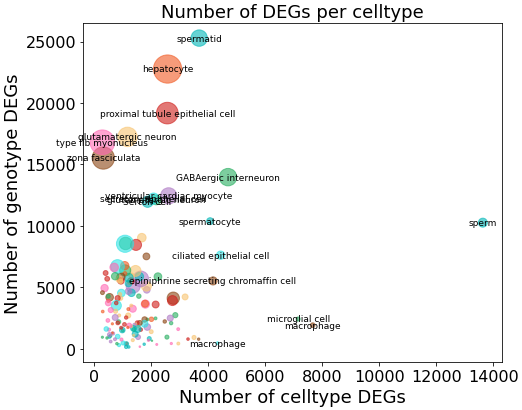

In [16]:
tissue_dict = {
    'CortexHippocampus': '#F8C471',  
    'Heart': '#AF7AC5',             
    'Liver': '#F15922',               
    'DiencephalonPituitary': '#27AE60',  
    'Adrenal': '#8B4513',        
    'Kidney': '#CF1E1A',              
    'Gastrocnemius': '#FF69B4',        
    'GonadsFemale': '#2FE3E5',       
    'GonadsMale': '#00B7B8'     
}


merged_df['tissue_color'] = merged_df['tissue'].map(tissue_dict)

plt.figure(figsize=(7.5, 6.25))
scatter = plt.scatter(
    x = merged_df['ct_gene_count'], 
    y = merged_df['geno_gene_count'],
    s=merged_df['percent_cells'] * 10,  
    c=merged_df['tissue_color'], 
    alpha=0.6, 
)

handles, labels = [], []
for genotype, color in tissue_dict.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
    labels.append(genotype)

plt.xlabel('Number of celltype DEGs',fontsize=18)
plt.ylabel('Number of genotype DEGs',fontsize=18)
plt.title('Number of DEGs per celltype',fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Label points with x > 4000 or y > 10,000
for i, row in merged_df.iterrows():
    if row['ct_gene_count'] > 4000 or row['geno_gene_count'] > 10000:
        plt.text(
            row['ct_gene_count'], 
            row['geno_gene_count'], 
            row['subtype'],  # You can use any identifier here, like gene name or index
            fontsize=9, 
            ha='center', 
            va='center', 
            color='black')

plt.show()



# Fig. 2c

In [17]:
import pandas as pd
import PyComplexHeatmap as pch
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [18]:
res = 0.2
prop = 0.75

In [19]:
tissues = ['CortexHippocampus',
           'DiencephalonPituitary' ,
           'Heart', 
           'GonadsFemale', 
           'Adrenal',
           'Gastrocnemius', 
           'Kidney', 
           'Liver',
           'GonadsMale'
          ]

## Read in subclustering results
Old results...

In [20]:
all_tissues_data = []

for tissue in tissues:
    chisq_results = pd.read_csv(
        f"/share/crsp/lab/seyedam/share/igvf_pipeline/figures/subclustering_subtypes/{tissue}/{tissue}_proportion_results_fixed_prop{prop}_res{res}_fixed_hvgs_1217.csv", 
        index_col=0
    )
    chisq_results = chisq_results[chisq_results['subtype'] != 'low quality']
    grouped_df = chisq_results.groupby(['Genotype', 'subtype']).agg({
        'ncells_specific_cluster': 'sum',
        'ncells_total': 'sum'
    }).reset_index()
    
    grouped_df['percentage_cells'] = (grouped_df['ncells_specific_cluster'] / grouped_df['ncells_total']) * 100
    grouped_df['Tissue'] = tissue
    all_tissues_data.append(grouped_df)

combined_df = pd.concat(all_tissues_data)
combined_df['subtype_tissue'] = combined_df['subtype'] + ' (' + combined_df['Tissue'] + ')'



In [21]:
heatmap_df = combined_df.pivot_table(
    index=['subtype_tissue','Tissue', 'subtype'], 
    columns='Genotype', 
    values='percentage_cells',
    fill_value=0 
).reset_index()

plot_df = heatmap_df.set_index('subtype_tissue').drop(columns=['Tissue', 'subtype'])
plot_df = plot_df.fillna(0)


## Get size of celltypes, and sort by proportion in tissue

In [22]:
df_row = heatmap_df[['subtype_tissue', 'subtype', 'Tissue']]
df_row = df_row.drop_duplicates()

sizes = pd.read_csv('/share/crsp/lab/seyedam/share/igvf_pipeline/IGVF_analysis/cellbender_tissues/obs_tables/all_tissues_annotated_metadata.csv')
cell_counts = sizes.groupby(['subtype', 'Tissue']).size().reset_index(name='num_cells')
total_cells_per_tissue = cell_counts.groupby('Tissue')['num_cells'].sum().reset_index(name='total_cells')
cell_counts = cell_counts.merge(total_cells_per_tissue, on='Tissue')
cell_counts['percent_cells'] = (cell_counts['num_cells'] / cell_counts['total_cells']) * 100

df_row = df_row.merge(cell_counts, on=['subtype', 'Tissue'], how='left')
df_row = df_row.set_index('subtype_tissue')
df_row['Tissue'] = pd.Categorical(df_row['Tissue'], categories=tissues, ordered=True)
df_row = df_row.sort_values(by=['Tissue', 'num_cells'], ascending=[True, False])


/tmp/ipykernel_1878618/2613650832.py:4: DtypeWarning: Columns (27,31,33,43,54,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  sizes = pd.read_csv('/share/crsp/lab/seyedam/share/igvf_pipeline/IGVF_analysis/cellbender_tissues/obs_tables/all_tissues_annotated_metadata.csv')


In [23]:
tissue_dict = {
    'CortexHippocampus': '#F8C471',  
    'Heart': '#AF7AC5',             
    'Liver': '#F15922',               
    'DiencephalonPituitary': '#27AE60',  
    'Adrenal': '#8B4513',        
    'Kidney': '#CF1E1A',              
    'Gastrocnemius': '#FF69B4',        
    'GonadsFemale': '#2FE3E5',       
    'GonadsMale': '#00B7B8'     
}

geno_dict = {
    '129S1J': '#DA9CC1',  
    'AJ': '#F4C245',             
    'B6J': '#C0BFBF',               
    'CASTJ': '#55AF5B',  
    'NODJ': '#4F6EAF',        
    'NZOJ': '#52A5DB',              
    'PWKJ': '#D83026',        
    'WSBJ': '#683C91'   
}

strain_dict = {'Lab': 'darkgrey', 'Wild': '#d3a021'}


df_col = pd.DataFrame({
    "Genotype": plot_df.columns,
    "Strain type": ["Wild" if x in ["CASTJ","PWKJ","WSBJ"] else "Lab" for x in plot_df.columns]
})
df_col = df_col.drop_duplicates()

genotype_categories = ['AJ','B6J','129S1J','NODJ','NZOJ','CASTJ','PWKJ','WSBJ']
df_col['Genotype'] = pd.Categorical(df_col['Genotype'], categories=genotype_categories, ordered=True)
df_col.sort_values(['Genotype'], inplace=True)
df_col = df_col.set_index("Genotype", drop=False)

col_ha = pch.HeatmapAnnotation(Genotype=pch.anno_simple(df_col['Genotype'],colors=geno_dict),
                               Type=pch.anno_simple(df_col['Strain type'],colors=strain_dict),
                               verbose=1,
                               label_kws = {'visible': False},
                               axis=1)

left_ha = pch.HeatmapAnnotation(Tissue=pch.anno_simple(df_row['Tissue'],colors=tissue_dict),vmin=0,
                                label_kws = {'visible': False},
                                plot_kws={'vmax': 100},
                                axis=0)


## Plot full subclustering results

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 50.65416666666667 mm


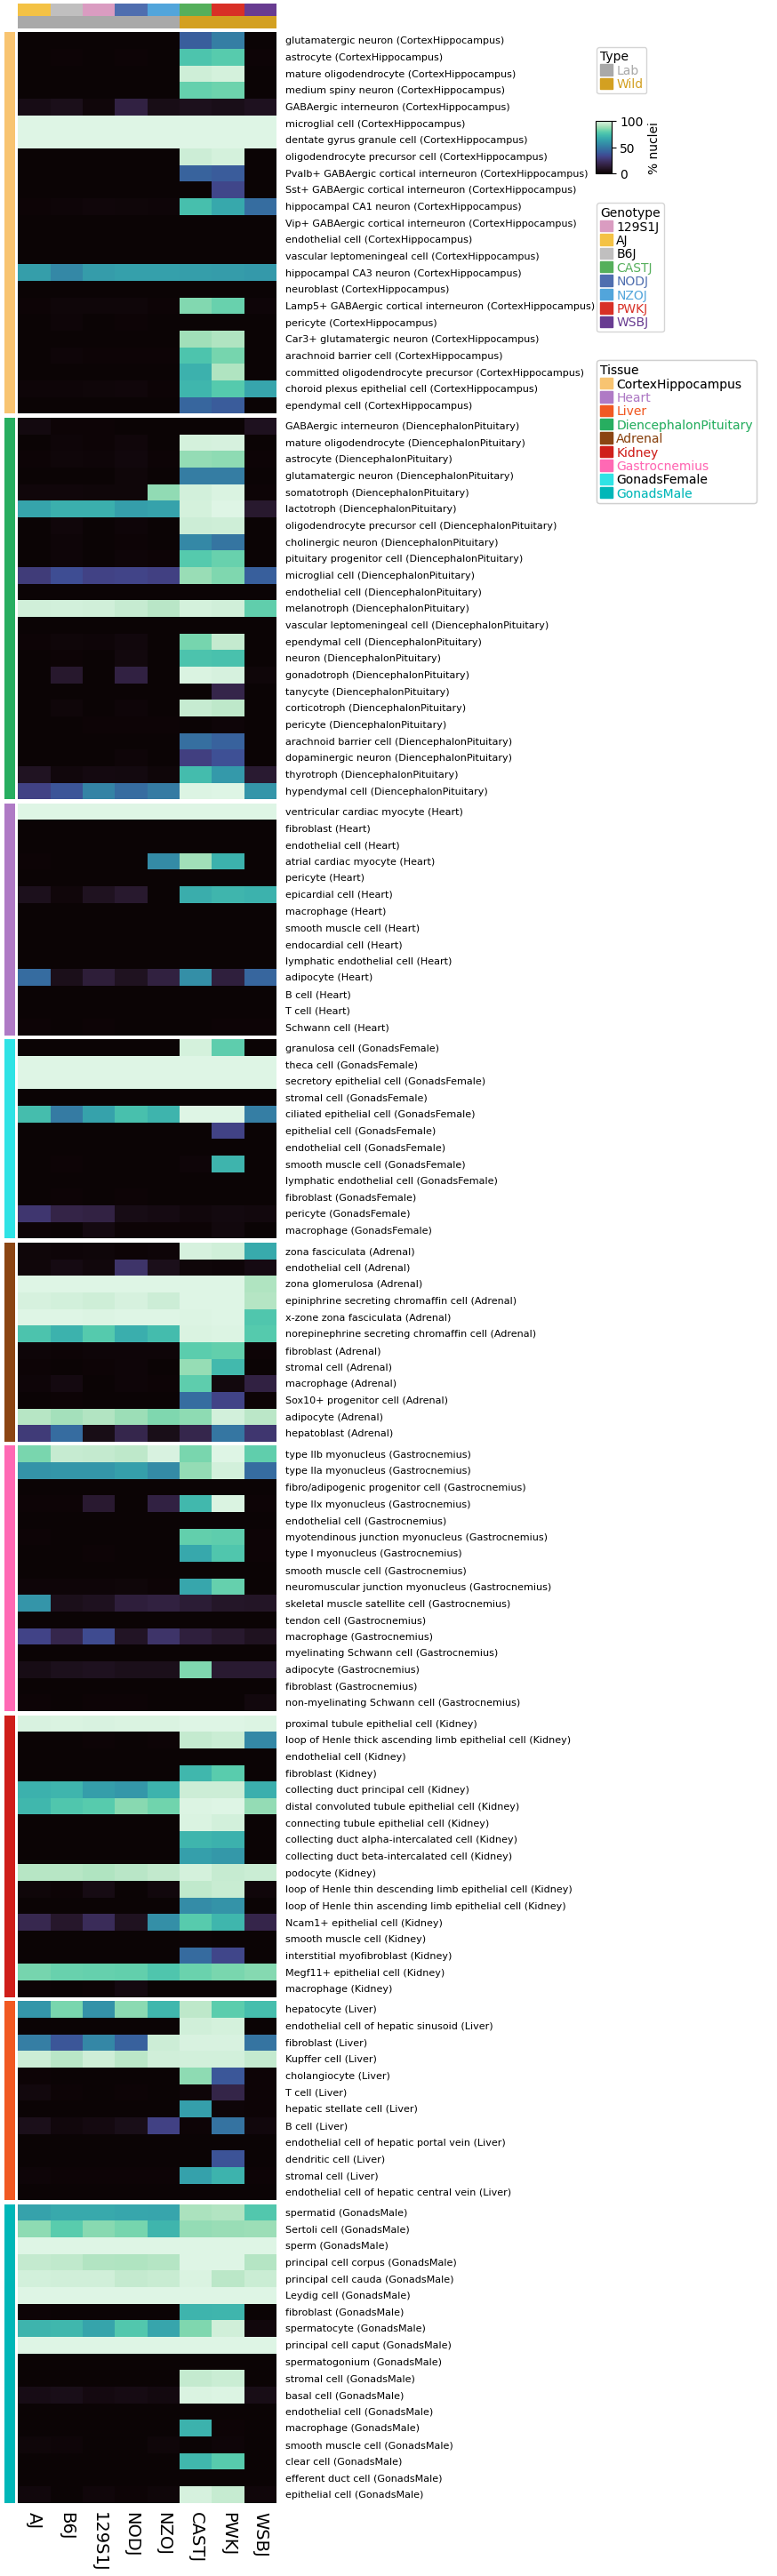

In [24]:
plt.figure(figsize=(4, 32), dpi = 100)

cm = pch.ClusterMapPlotter(data=plot_df.loc[df_row.index.tolist(),df_col.index.tolist()],
                           show_rownames = True, 
                           show_colnames = True, 
                           cmap = "mako",
                           label = "% nuclei",
                           top_annotation=col_ha, 
                           left_annotation=left_ha,
                           row_cluster=False,
                           col_cluster=False,
                           row_split_gap = 1,
                           row_split = df_row['Tissue'],
                           row_split_order = tissues,
                           yticklabels_kws={'labelsize': 8},
                           xticklabels_kws={'labelsize': 14} 
                          )

plt.show()


## Filter to cell types >5% of tissue

In [25]:
keep = cell_counts[cell_counts['percent_cells'] > 5]
keep['subtype_tissue'] = keep['subtype'] + ' (' + keep['Tissue'] + ')'
keep.shape

/tmp/ipykernel_1878618/3291646461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keep['subtype_tissue'] = keep['subtype'] + ' (' + keep['Tissue'] + ')'


(40, 6)

In [26]:
filtered_plot_df = plot_df[plot_df.index.isin(keep['subtype_tissue'])]
filtered_plot_df.reset_index(inplace = True)
filtered_df_row = df_row[df_row.index.isin(keep['subtype_tissue'])]
filtered_df_row.reset_index(inplace = True)


In [27]:
# check which subtypes appear in multiple tissues
subtype_tissue_counts = filtered_df_row.groupby('subtype')['Tissue'].nunique()

# update 'unique_subtype' column based on whether the subtype is in multiple tissues
def modify_unique_subtype(row, subtype_tissue_counts):
    if subtype_tissue_counts[row['subtype']] > 1:
        # add tissue name
        return f"{row['subtype']} ({row['Tissue']})"
    else:
        return row['subtype']

filtered_df_row['unique_subtype'] = filtered_df_row.apply(lambda row: modify_unique_subtype(row, subtype_tissue_counts), axis=1)
filtered_plot_df = pd.merge(filtered_plot_df, filtered_df_row[['subtype_tissue', 'unique_subtype']], on='subtype_tissue')
filtered_plot_df = filtered_plot_df.set_index("unique_subtype").drop(columns=["subtype_tissue"])
filtered_df_row = filtered_df_row.set_index("unique_subtype")


/tmp/ipykernel_1878618/4057765887.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_row['unique_subtype'] = filtered_df_row.apply(lambda row: modify_unique_subtype(row, subtype_tissue_counts), axis=1)


In [28]:
left_ha_filt = pch.HeatmapAnnotation(Tissue=pch.anno_simple(filtered_df_row['Tissue'],colors=tissue_dict),
                                     label_kws = {'visible': False},
                                     plot_kws={'vmax': 100},
                                     axis=0)


## Plot

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 50.65416666666667 mm


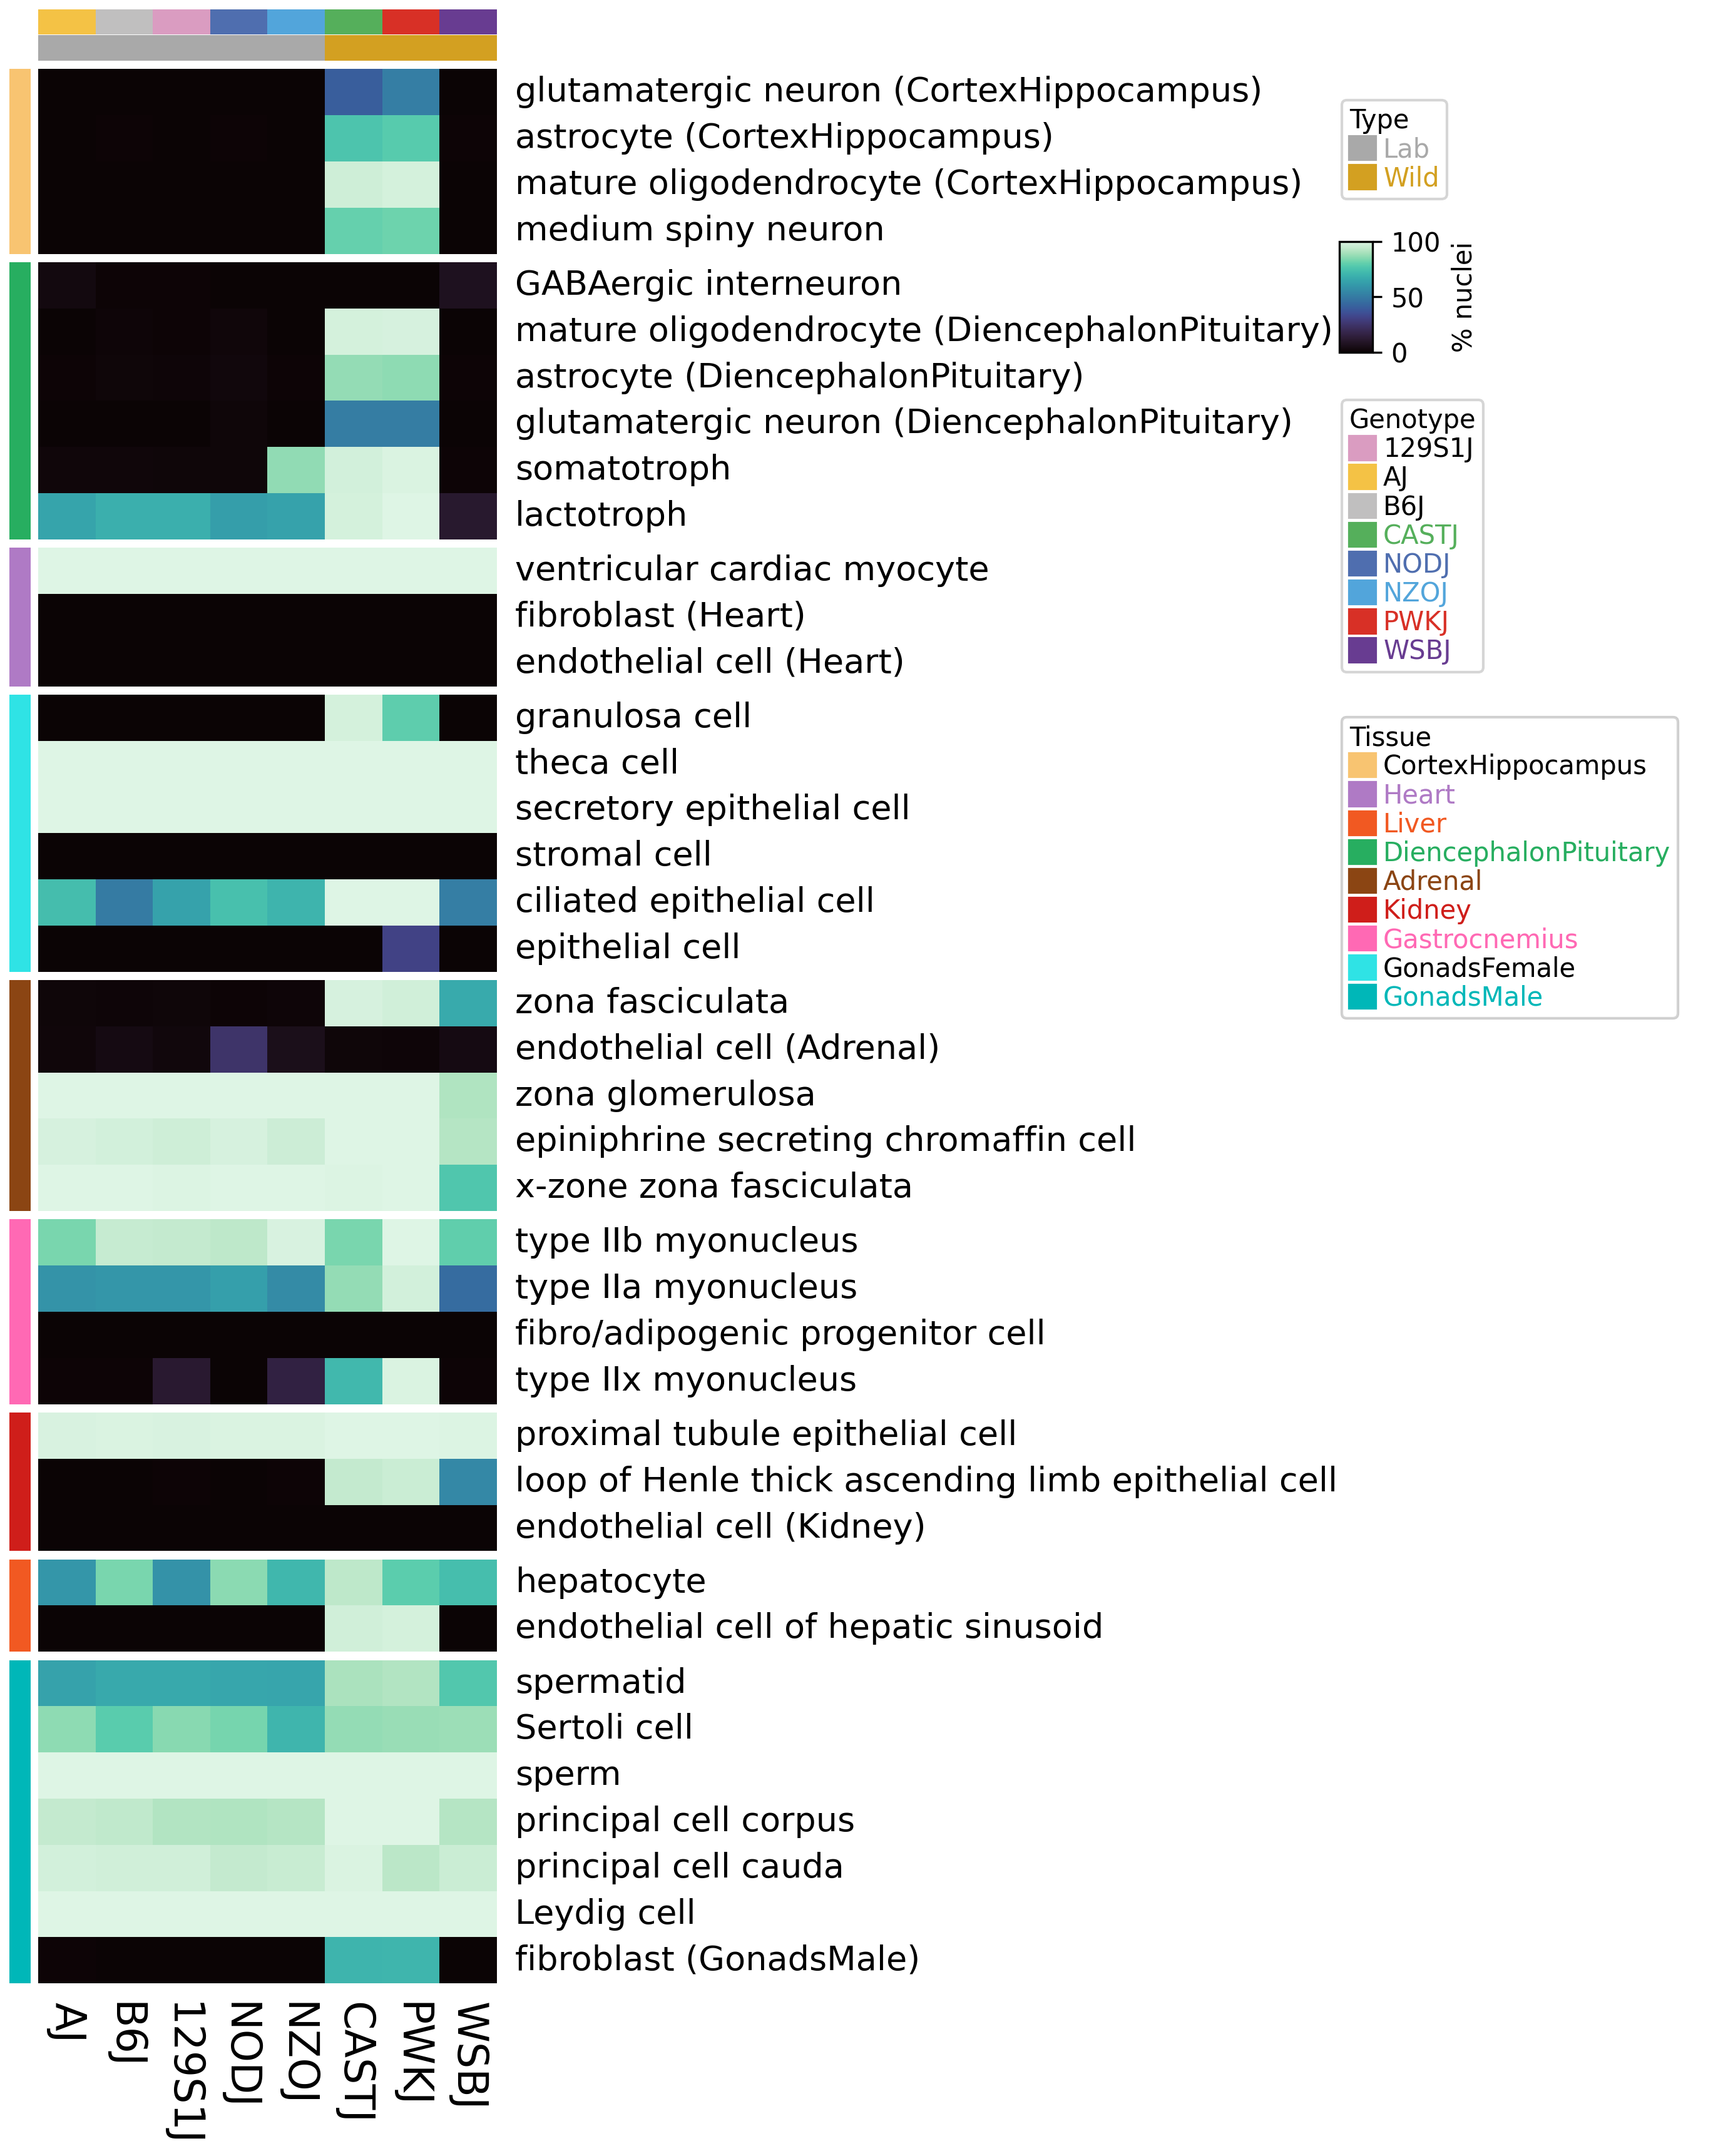

In [29]:
plt.figure(figsize=(3.4, 12), dpi = 300)

cm = pch.ClusterMapPlotter(data=filtered_plot_df.loc[filtered_df_row.index.tolist(),df_col.index.tolist()],
                           show_rownames = True, 
                           show_colnames = True, 
                           cmap = "mako",
                           label = "% nuclei",
                           top_annotation=col_ha, 
                           left_annotation=left_ha_filt,
                           row_cluster=False,
                           col_cluster=False,
                           row_split_gap = 1,
                           row_split = filtered_df_row['Tissue'],
                           row_split_order = tissues,
                           yticklabels_kws={'labelsize': 13},
                           xticklabels_kws={'labelsize': 16} 
                          )

plt.show()


## Read in DEG results
Both celltype and genotype.

In [30]:
lfc_cutoff = 1
padj_cutoff = 0.01

In [31]:
merged_all_tissues = []
for tissue in tissues:
    
    df_genes = pd.read_csv(f'/share/crsp/lab/seyedam/share/igvf_pipeline/figures/degs_old_pbulk_strategy/{tissue}/results_de_analysis_celltypes_no_min_cells.csv')
    ct_degs = df_genes[(df_genes['log2FoldChange'] >= lfc_cutoff) & (df_genes['padj'] <= padj_cutoff)]
    ct_degs = ct_degs[['gene_name','subtype', 'tissue']].drop_duplicates()

    geno_degs_unfilt = pd.read_csv('/share/crsp/lab/seyedam/share/igvf_pipeline/figures/specificity/sig_degs_all_tissues_b6j.csv', index_col = 0)
    geno_degs = geno_degs_unfilt[geno_degs_unfilt['tissue'] == tissue]
    geno_degs.rename(columns={'celltype': 'subtype'}, inplace=True)
    geno_degs = geno_degs[['gene_name', 'subtype', 'genotype', 'tissue']].drop_duplicates()
    
    merged_df = pd.merge(geno_degs, ct_degs, on=['gene_name', 'subtype', 'tissue'])
    
    merged_all_tissues.append(merged_df)
    
final_merged_df = pd.concat(merged_all_tissues, ignore_index=True)


/tmp/ipykernel_1878618/280533944.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geno_degs.rename(columns={'celltype': 'subtype'}, inplace=True)
/tmp/ipykernel_1878618/280533944.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geno_degs.rename(columns={'celltype': 'subtype'}, inplace=True)
/tmp/ipykernel_1878618/280533944.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geno_degs.rename(columns={'celltype': 'subtype'}, inp

In [32]:
final_merged_df['subtype_tissue'] = final_merged_df['subtype'] + ' (' + final_merged_df['tissue'] + ')'

# Group by genotype and subtype and count unique gene_names
gene_counts = final_merged_df.groupby(['genotype', 'subtype_tissue'])['gene_name'].nunique().unstack(fill_value=0)
gene_counts=gene_counts.transpose()
gene_counts['B6J'] = 0

In [33]:
df_row['subtype_tissue'] = df_row.index
filtered_df_row_degs = df_row[df_row['subtype_tissue'].isin(gene_counts.index)]
gene_count_df = gene_counts.loc[filtered_df_row_degs['subtype_tissue'].unique().tolist(),df_col.index.tolist()]


## Normalize DEG df within tissue

In [34]:
# Merge df and df_row to associate tissues with the main DataFrame
df_with_tissue = gene_count_df.merge(filtered_df_row_degs[['Tissue']], left_index=True, right_index=True)

normalized_dfs = [] 

for tissue in tissues:
    df_with_tissue_this_tiss = df_with_tissue[df_with_tissue['Tissue'] == tissue]
    df_with_tissue_this_tiss = df_with_tissue_this_tiss.drop(columns='Tissue')  
    max_value = df_with_tissue_this_tiss.max().max()  # Get max value for this tissue
    
    normalized_df = df_with_tissue_this_tiss / max_value  # Normalize by max value
    normalized_df['Tissue'] = tissue  
    
    normalized_dfs.append(normalized_df)  # Store in list

normalized_df = pd.concat(normalized_dfs)
normalized_df = normalized_df.drop(columns='Tissue')


In [35]:
left_ha_filt_degs = pch.HeatmapAnnotation(Tissue=pch.anno_simple(filtered_df_row_degs['Tissue'],
                                                                 colors=tissue_dict),
                                          label_kws = {'visible': False},
                                          plot_kws={'vmax': 100},
                                          axis=0)


## Plot full DEG results

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 50.65416666666667 mm


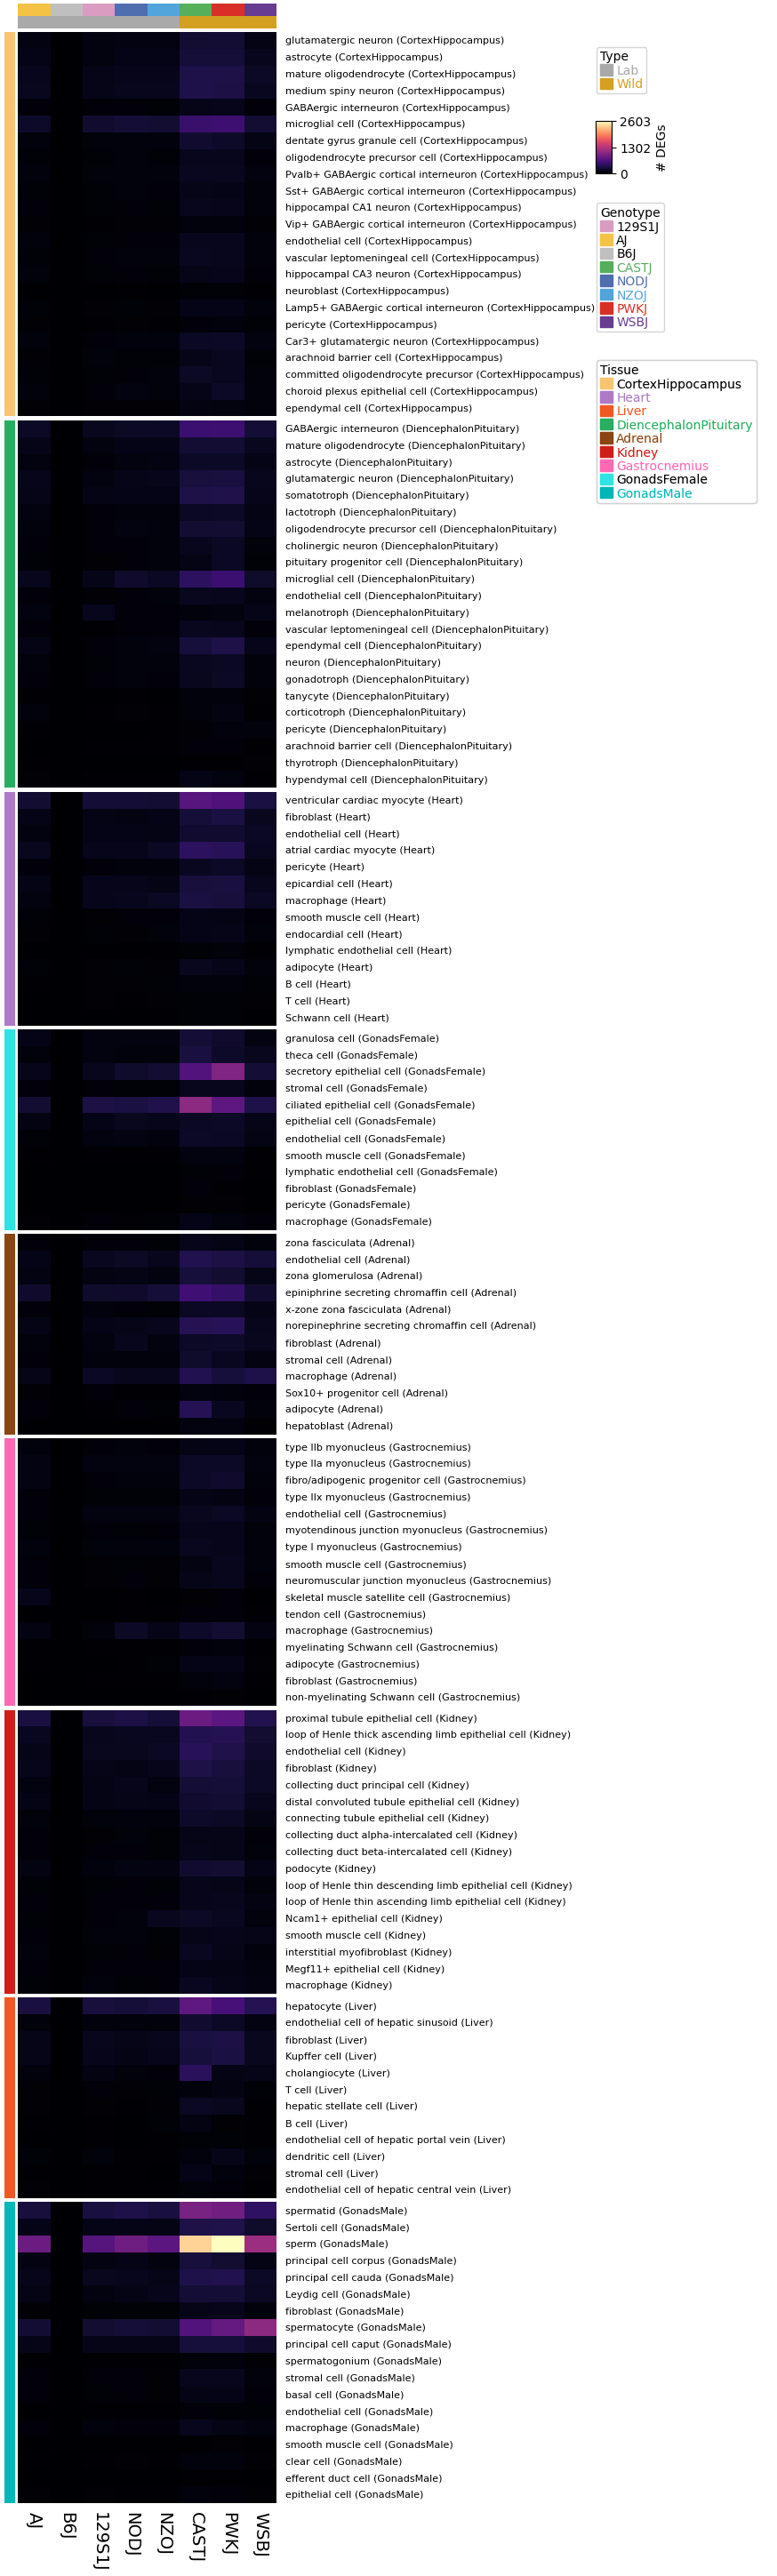

In [36]:
plt.figure(figsize=(4, 32), dpi = 100)

cm = pch.ClusterMapPlotter(data=gene_count_df.loc[filtered_df_row_degs.index.tolist(),df_col.index.tolist()],
                           show_rownames = True, 
                           show_colnames = True, 
                           cmap = "magma",
                           label = "# DEGs",
                           top_annotation=col_ha, 
                           left_annotation=left_ha_filt_degs,
                           row_cluster=False,
                           col_cluster=False,
                           row_split_gap = 1,
                           row_split = filtered_df_row_degs['Tissue'],
                           row_split_order = tissues,
                           yticklabels_kws={'labelsize': 8},
                           xticklabels_kws={'labelsize': 14} 
                          )

plt.show()


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 50.65416666666667 mm


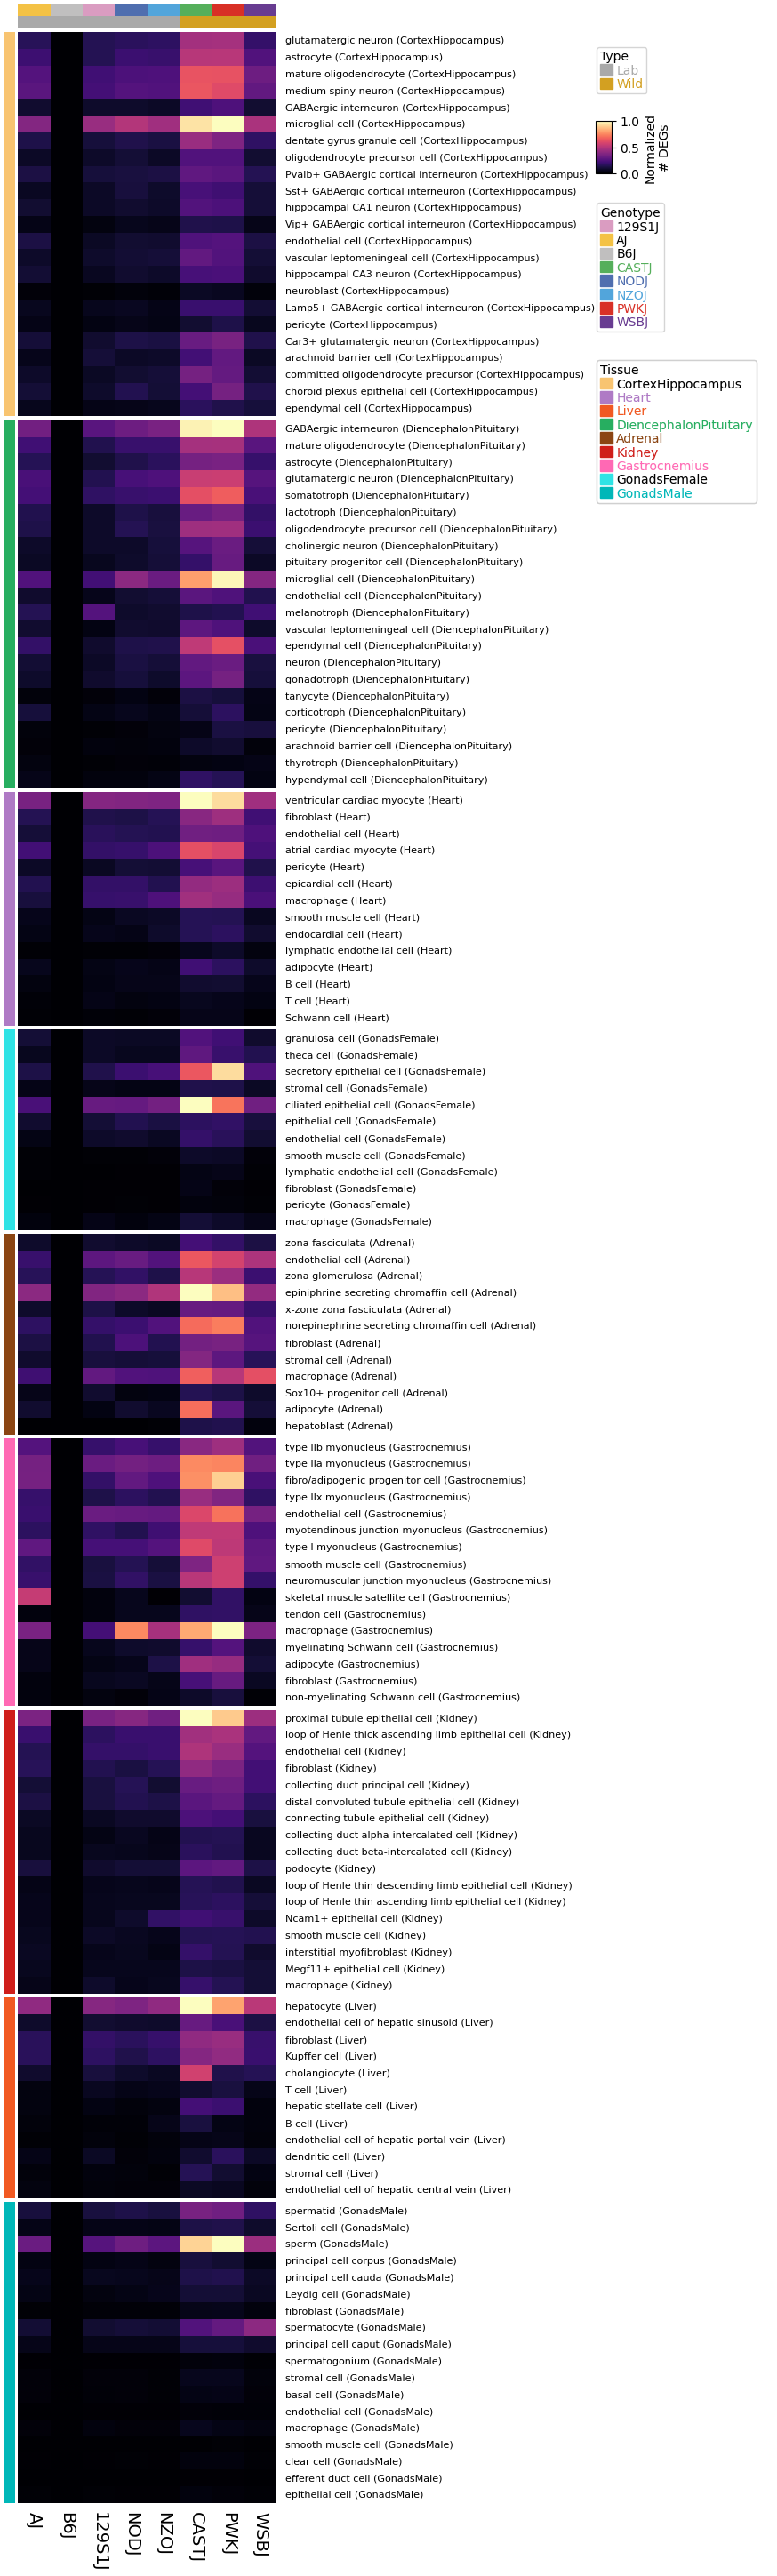

In [37]:
plt.figure(figsize=(4, 32), dpi = 100)

cm = pch.ClusterMapPlotter(data=normalized_df.loc[filtered_df_row_degs.index.tolist(),df_col.index.tolist()],
                           show_rownames = True, 
                           show_colnames = True, 
                           cmap = "magma",
                           label = "Normalized\n# DEGs",
                           top_annotation=col_ha, 
                           left_annotation=left_ha_filt_degs,
                           row_cluster=False,
                           col_cluster=False,
                           row_split_gap = 1,
                           row_split = filtered_df_row_degs['Tissue'],
                           row_split_order = tissues,
                           yticklabels_kws={'labelsize': 8},
                           xticklabels_kws={'labelsize': 14} 
                          )

plt.show()


## Filter celltypes

In [38]:
filtered_normalized_df = normalized_df[normalized_df.index.isin(keep['subtype_tissue'])]
filtered_normalized_df.reset_index(inplace = True)

filtered_df_row_degs_final = filtered_df_row_degs[filtered_df_row_degs.index.isin(keep['subtype_tissue'])]
filtered_df_row_degs_final.drop(columns='subtype_tissue', inplace = True)


/tmp/ipykernel_1878618/3547065018.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_row_degs_final.drop(columns='subtype_tissue', inplace = True)


In [39]:
# check which subtypes appear in multiple tissues
subtype_tissue_counts = filtered_df_row_degs_final.groupby('subtype')['Tissue'].nunique()

filtered_df_row_degs_final['unique_subtype'] = filtered_df_row_degs_final.apply(lambda row: modify_unique_subtype(row, subtype_tissue_counts), axis=1)
filtered_normalized_df = pd.merge(filtered_normalized_df, filtered_df_row_degs_final[['unique_subtype']], on='subtype_tissue')
filtered_normalized_df = filtered_normalized_df.set_index("unique_subtype").drop(columns=["subtype_tissue"])
filtered_df_row_degs_final = filtered_df_row_degs_final.set_index("unique_subtype")


/tmp/ipykernel_1878618/3639457298.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_row_degs_final['unique_subtype'] = filtered_df_row_degs_final.apply(lambda row: modify_unique_subtype(row, subtype_tissue_counts), axis=1)


In [40]:
left_ha_filt_degs_final = pch.HeatmapAnnotation(Tissue=pch.anno_simple(filtered_df_row_degs_final['Tissue'],colors=tissue_dict),
                                                label_kws = {'visible': False},
                                                plot_kws={'vmax': 100},
                                                axis=0)


## Plot

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 50.65416666666667 mm


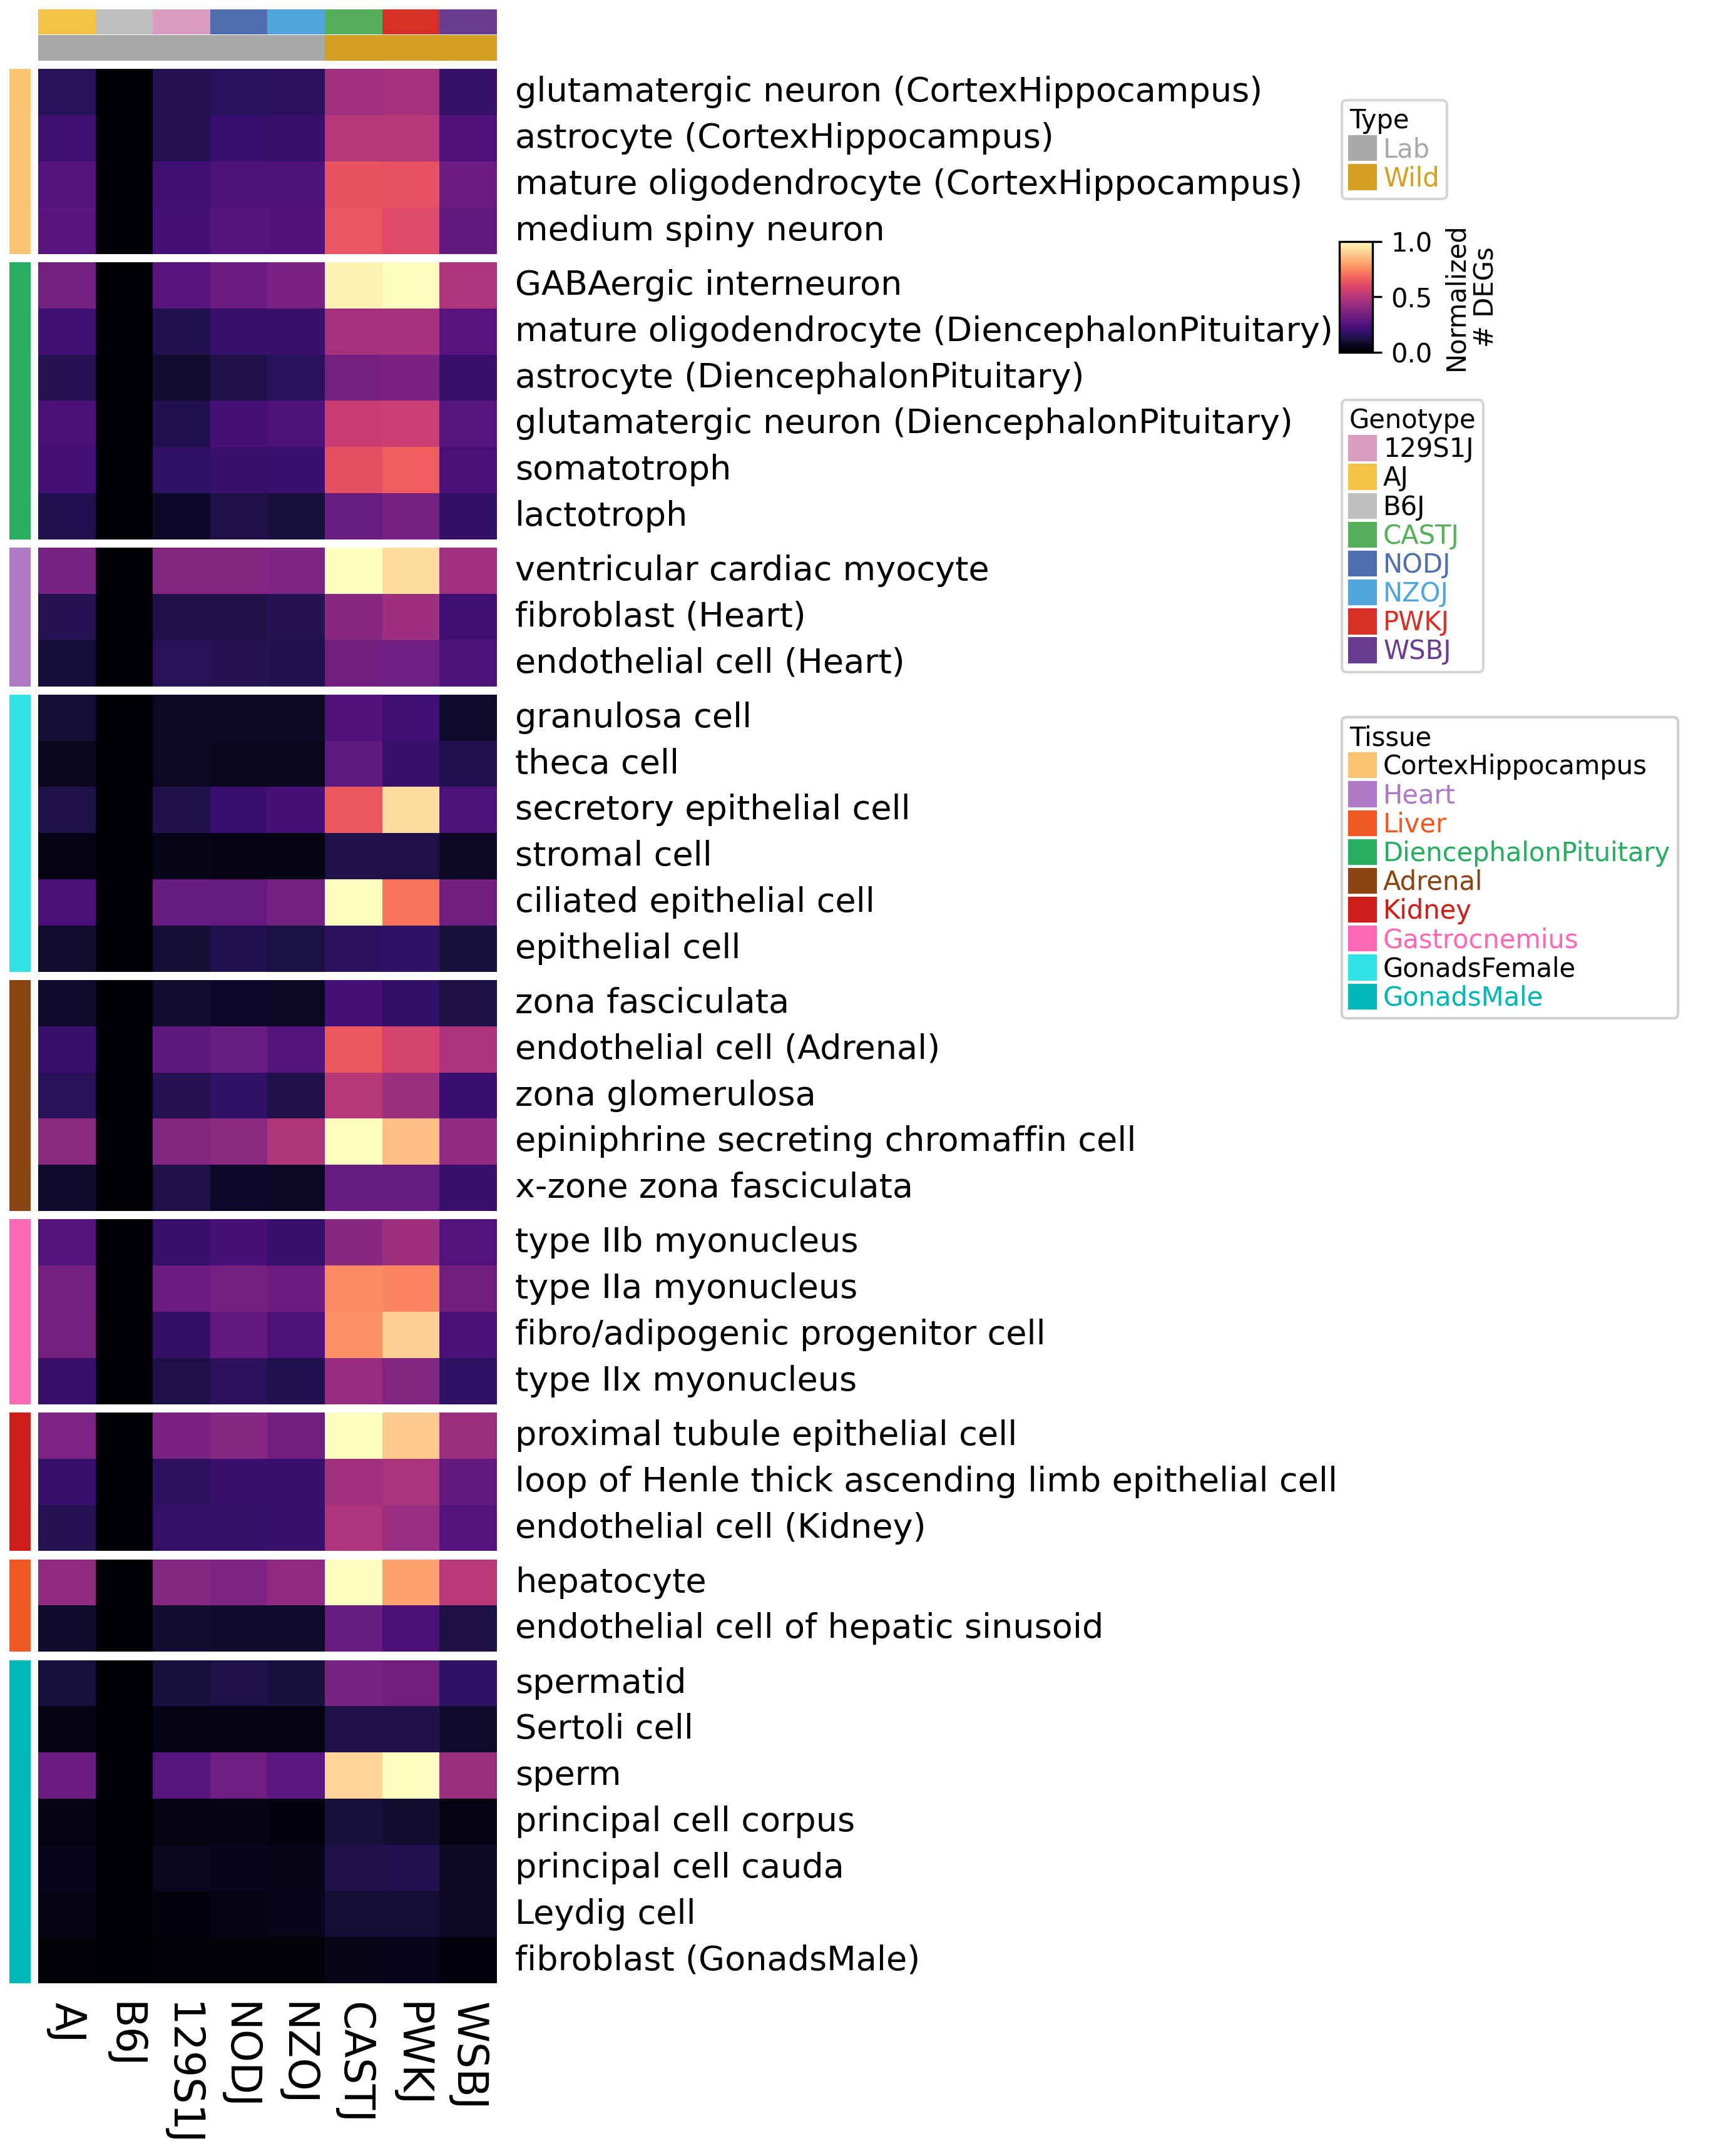

In [41]:
plt.figure(figsize=(3.4, 12), dpi = 300)

cm = pch.ClusterMapPlotter(data=filtered_normalized_df.loc[filtered_df_row_degs_final.index.tolist(),df_col.index.tolist()],
                           show_rownames = True, 
                           show_colnames = True, 
                           cmap = "magma",
                           label = "Normalized\n# DEGs",
                           top_annotation=col_ha, 
                           left_annotation=left_ha_filt_degs_final,
                           row_cluster=False,
                           col_cluster=False,
                           row_split_gap = 1,
                           row_split = filtered_df_row_degs_final['Tissue'],
                           row_split_order = tissues,
                           yticklabels_kws={'labelsize': 13},
                           xticklabels_kws={'labelsize': 16} 
                          )

plt.show()


# Fig. 2d

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_indicators


## Select celltype of interest
proxtubes..

In [43]:
celltype = 'proximal tubule epithelial cell'
upset_df = final_merged_df[final_merged_df['subtype'] == celltype]
upset_df = upset_df[['gene_name', 'genotype']].drop_duplicates()

## Make upset matrix

In [44]:
binary_matrix = upset_df.pivot_table(index='gene_name', columns='genotype', aggfunc=lambda x: 1, fill_value=0)
binary_matrix = binary_matrix.astype(bool)  # Convert 0/1 to True/False


## Plot

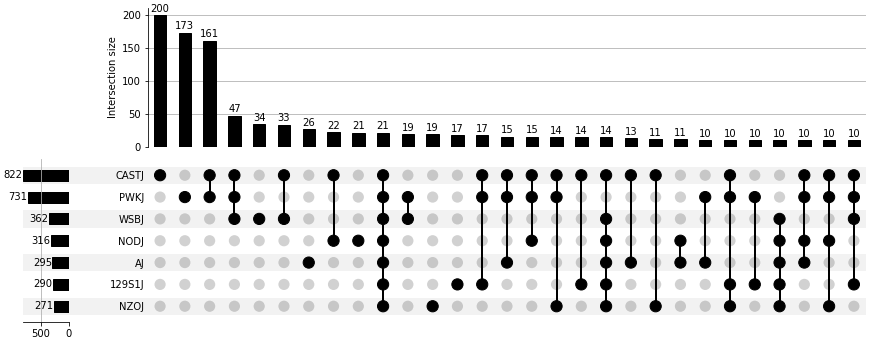

In [45]:
upset_data = from_indicators(binary_matrix.columns, binary_matrix)

upset = UpSet(upset_data, sort_by = 'cardinality', 
              sort_categories_by = '-cardinality',
              subset_size='count',
              max_subset_rank=25,
              show_counts = True
             )
upset.plot()
plt.savefig(f"../fig2/{celltype}_upset_plot.png", dpi=300, bbox_inches="tight")  
plt.savefig(f"../fig2/{celltype}_upset_plot.pdf", dpi=300, bbox_inches="tight") 

plt.show()

# Fig. 2e

In [46]:
genotypes = ['AJ','129S1J','NODJ','NZOJ','CASTJ','PWKJ','WSBJ']

import gseapy as gp
import numpy as np
import re


def truncate_term(term, max_length):
    if len(term) > max_length:
        return term[:max_length] + '...'
    return term

## Read in DEG results
Keeping track of up/down regulated just in case

In [47]:
merged_all_tissues = []
for tissue in tissues:
    
    df_genes = pd.read_csv(f'/share/crsp/lab/seyedam/share/igvf_pipeline/figures/degs_old_pbulk_strategy/{tissue}/results_de_analysis_celltypes_no_min_cells.csv')
    ct_degs = df_genes[(df_genes['log2FoldChange'] >= lfc_cutoff) & (df_genes['padj'] <= padj_cutoff)]
    ct_degs = ct_degs[['gene_name','subtype', 'tissue']].drop_duplicates()

    geno_degs_unfilt = pd.read_csv('/share/crsp/lab/seyedam/share/igvf_pipeline/figures/specificity/sig_degs_all_tissues_b6j.csv', index_col = 0)
    geno_degs = geno_degs_unfilt[geno_degs_unfilt['tissue'] == tissue]
    geno_degs.rename(columns={'celltype': 'subtype'}, inplace=True)
    mask = geno_degs['comparison'].str.contains('B6J_vs_')
    geno_degs.loc[mask, 'log2FoldChange'] = -geno_degs.loc[mask, 'log2FoldChange']
    geno_degs['direction'] = np.where(
    geno_degs['log2FoldChange'] > 0,
        "Upregulated", 
        "Downregulated")

    
    geno_degs = geno_degs[['gene_name', 'subtype', 'genotype', 'tissue','direction']].drop_duplicates()
    merged_df = pd.merge(geno_degs, ct_degs, on=['gene_name', 'subtype', 'tissue'])
    merged_all_tissues.append(merged_df)
    
final_merged_df = pd.concat(merged_all_tissues, ignore_index=True)
final_merged_df['subtype_tissue'] = final_merged_df['subtype'] + ' (' + final_merged_df['tissue'] + ')'



/tmp/ipykernel_1878618/2676792569.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geno_degs.rename(columns={'celltype': 'subtype'}, inplace=True)
/tmp/ipykernel_1878618/2676792569.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geno_degs['direction'] = np.where(
/tmp/ipykernel_1878618/2676792569.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geno_degs.rename(colum

## GO term bubble plot

In [48]:
tissue = "Kidney"
final_merged_df_one_at_a_time = final_merged_df[final_merged_df['tissue'] == tissue]
#final_merged_df_one_at_a_time = final_merged_df_one_at_a_time[final_merged_df_one_at_a_time['direction'] == 'Upregulated']

# just proxtubes for the figure
final_merged_df_one_at_a_time = final_merged_df_one_at_a_time[final_merged_df_one_at_a_time['subtype'] == 'proximal tubule epithelial cell']

subtype_tissues = final_merged_df_one_at_a_time['subtype_tissue'].unique().tolist()


Processing proximal tubule epithelial cell (Kidney)
Proportion of genes starting with 'Gm': 31.24%
Proportion of genes starting with 'ENSMUS': 4.30%
Proportion of genes ending with 'Rik': 8.37%
In proximal tubule epithelial cell (Kidney), AJ has 199 specific DEGs...
...and 6 enriched pathway(s).
In proximal tubule epithelial cell (Kidney), 129S1J has 190 specific DEGs...
...and 2 enriched pathway(s).
In proximal tubule epithelial cell (Kidney), NODJ has 202 specific DEGs...
...and 5 enriched pathway(s).
In proximal tubule epithelial cell (Kidney), NZOJ has 166 specific DEGs...
...and 2 enriched pathway(s).
In proximal tubule epithelial cell (Kidney), CASTJ has 541 specific DEGs...
...and 4 enriched pathway(s).
In proximal tubule epithelial cell (Kidney), PWKJ has 492 specific DEGs...
...and 1 enriched pathway(s).
In proximal tubule epithelial cell (Kidney), WSBJ has 240 specific DEGs...
...and 3 enriched pathway(s).


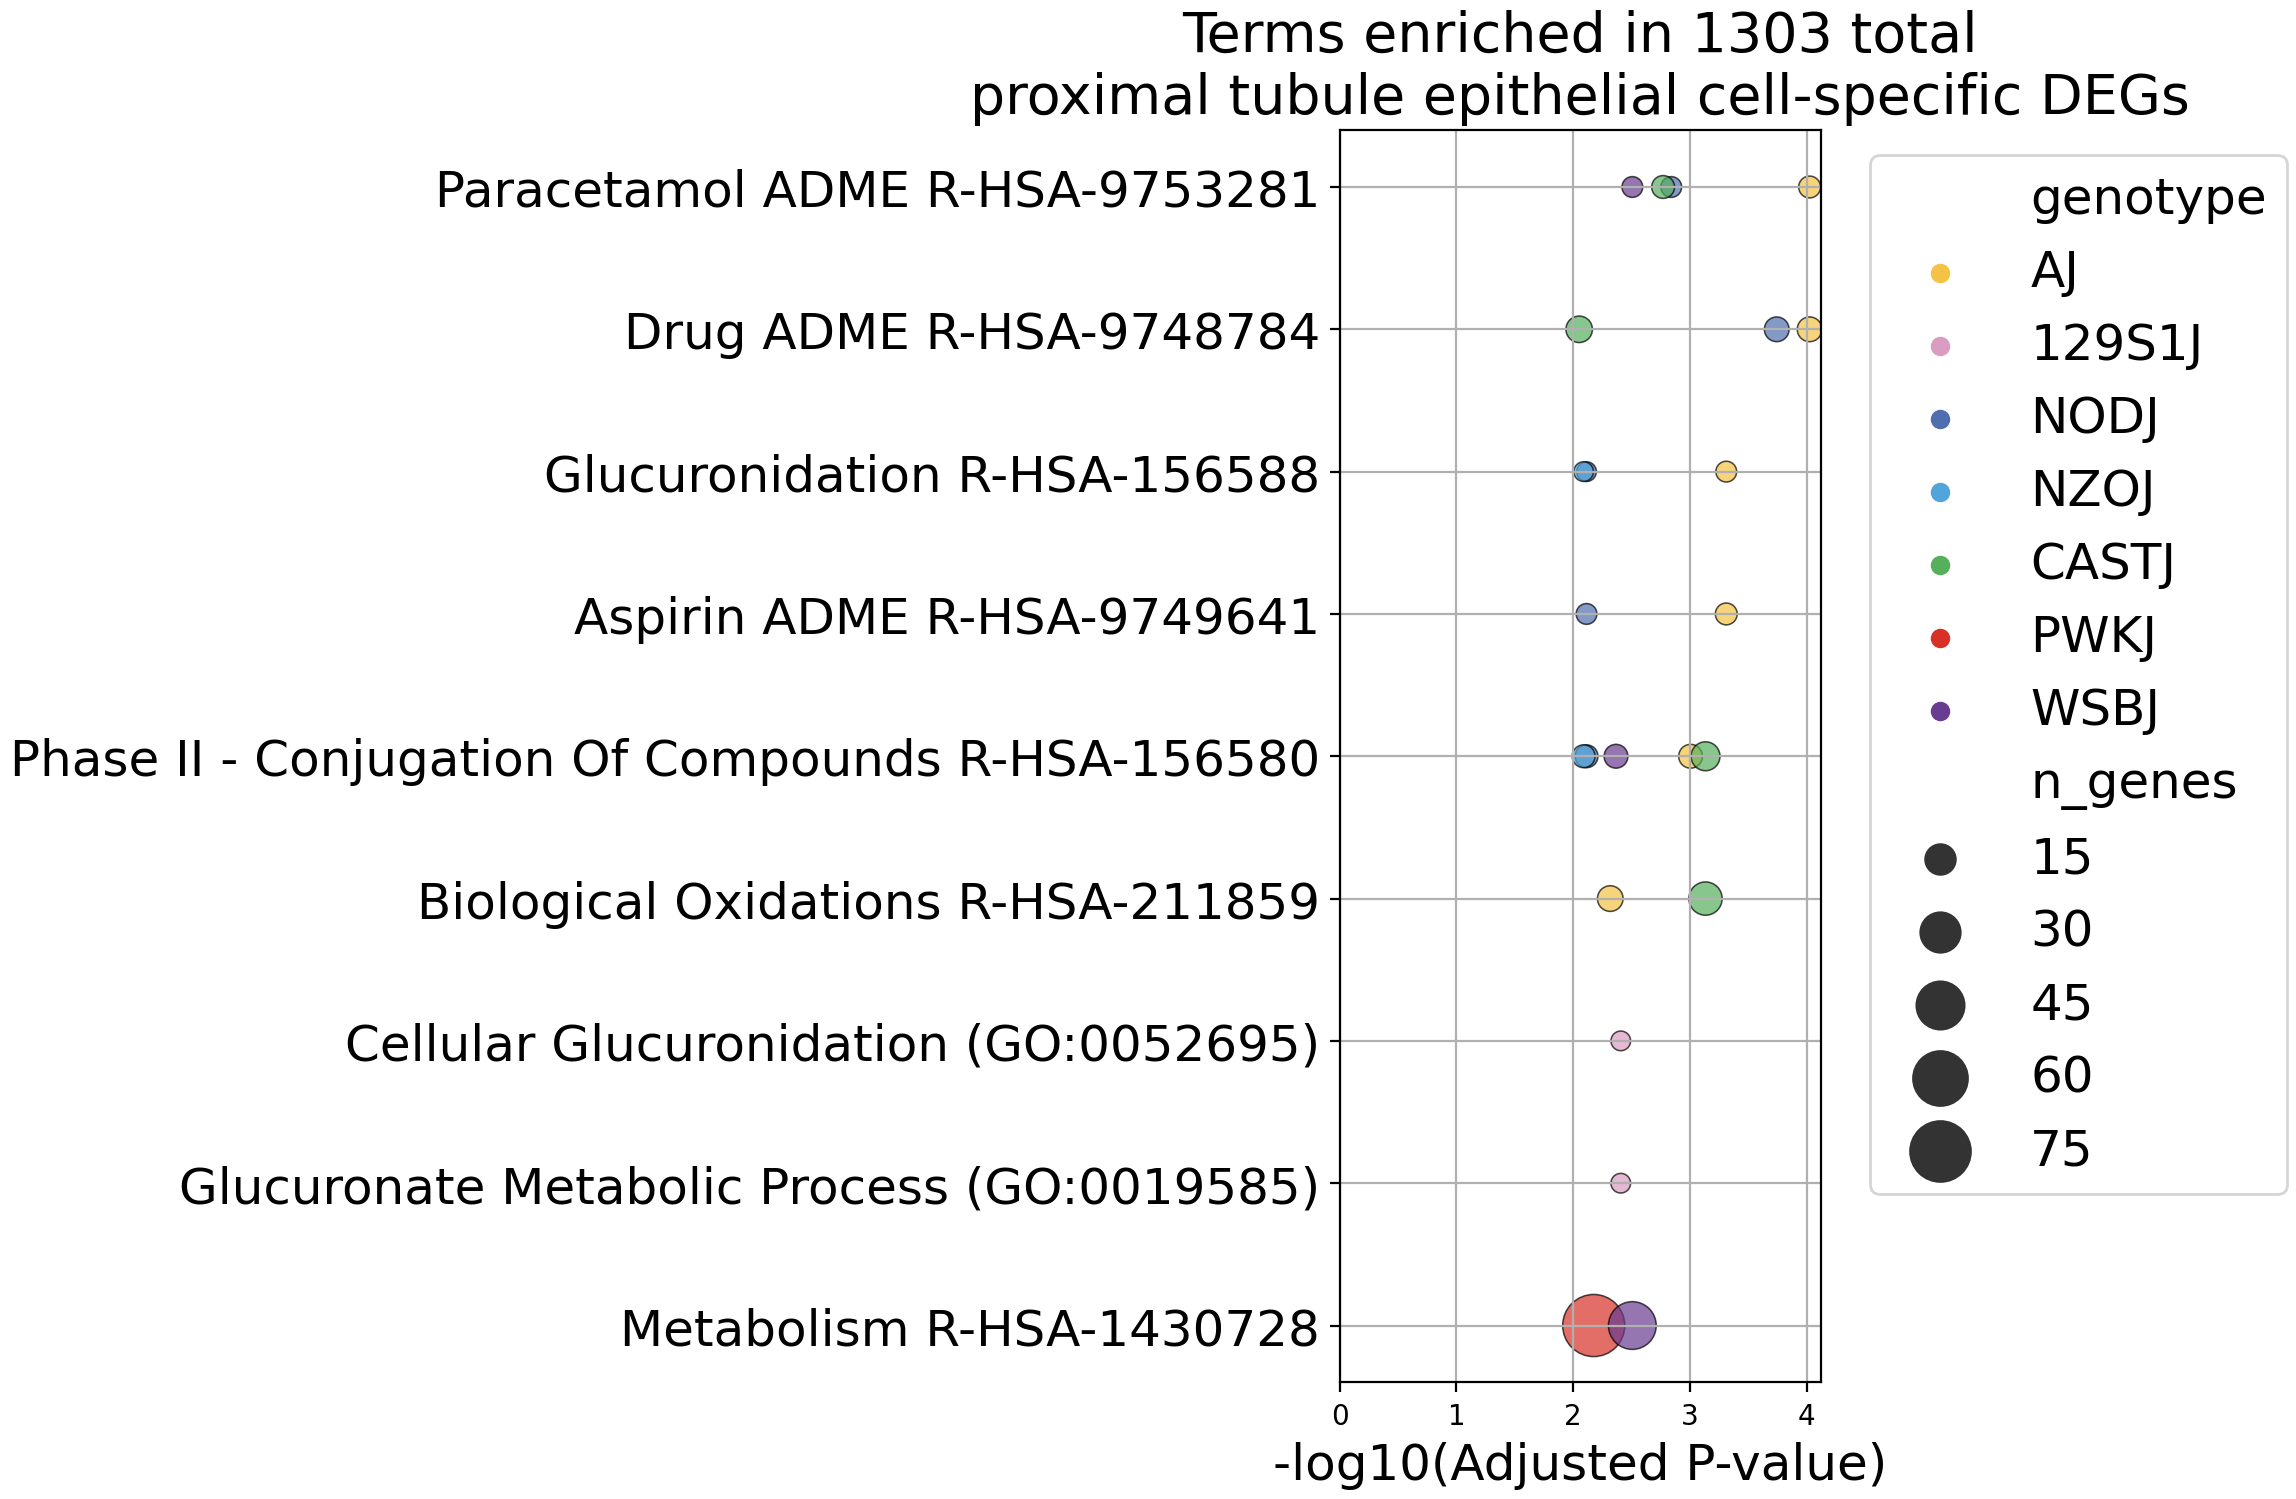

In [49]:
for subtype_tissue in subtype_tissues:
    
    print(f'Processing {subtype_tissue}')
    
    final_merged_df2 = final_merged_df_one_at_a_time[final_merged_df_one_at_a_time['subtype_tissue'] == subtype_tissue]
    n_genes = len(final_merged_df2['gene_name'].unique().tolist())
    
    if n_genes > 200:
        
        all_results = []
        
        genes = final_merged_df2['gene_name'].unique().tolist()
            
        # Count genes starting with "Gm"
        gm_count = sum(gene.startswith("Gm") for gene in genes)
        gm_prop = (gm_count / n_genes) * 100

        # Count genes starting with "ENSMUS"
        ensmus_count = sum(gene.startswith("ENSMUS") for gene in genes)
        ensmus_prop = (ensmus_count / n_genes) * 100

        # Count genes ending with "Rik"
        rik_count = sum(gene.endswith("Rik") for gene in genes)
        rik_prop = (rik_count / n_genes) * 100

        print(f"Proportion of genes starting with 'Gm': {gm_prop:.2f}%")
        print(f"Proportion of genes starting with 'ENSMUS': {ensmus_prop:.2f}%")
        print(f"Proportion of genes ending with 'Rik': {rik_prop:.2f}%")

        for genotype in genotypes:
            specific_genes_geno = final_merged_df2[final_merged_df2['genotype'] == genotype]

            genes = specific_genes_geno['gene_name'].unique().tolist()
            genes= [gene for gene in genes if not  re.match(r"Gm\d+", gene) ]
            # genes = [gene for gene in genes
            #          if not gene.startswith("ENSMUS") 
            #          and not re.match(r"Gm\d+", gene)  # Matches 'Gm' followed by one or more digits
            #          and not gene.endswith("Rik")
            #         ]

            print(f'In {subtype_tissue}, {genotype} has {len(genes)} specific DEGs...')

            enr = gp.enrichr(
                gene_list=genes,
                organism='Mouse', 
                gene_sets=['Reactome_2022', 'GO_Biological_Process_2023']
            )
            df = enr.results
            df = df.sort_values(by="Adjusted P-value", ascending=True)

            df['-log10(Adjusted P-value)'] = -np.log10(df['Adjusted P-value'])
            df = df[df['Adjusted P-value'] <= 0.01]

            print(f"...and {df.shape[0]} enriched pathway(s).")
            df['genotype'] = genotype

            all_results.append(df)

        final_results = pd.concat(all_results, ignore_index=True)
 
        if not final_results.empty:
            final_results['Truncated_Term'] = final_results['Term'].apply(lambda x: truncate_term(x, 50))  
            final_results['Overlap_Num'] = final_results['Overlap'].apply(lambda x: int(x.split('/')[0])) 
            final_results['n_genes'] = final_results['Genes'].apply(lambda x: len(x.split(';')))  
            final_results['genotype'] = pd.Categorical(final_results['genotype'], categories=genotypes, ordered=True)
            final_results['Color'] = final_results['genotype'].map(geno_dict)
            
            nterms = len(final_results['Truncated_Term'].unique().tolist())

            height =  8 + (nterms - 10) * 0.3
            plt.figure(figsize=(9, height), dpi = 200)
            sns.scatterplot(
                data=final_results,
                x='-log10(Adjusted P-value)',
                y='Truncated_Term',
                size='n_genes',
                hue='genotype',
                palette=geno_dict,
                sizes=(50, 500),  
                edgecolor='black',
                alpha=0.7
            )

            plt.xlim(0, None)
            plt.grid(True)

            celltype = subtype_tissue.split(' (')[0]
            plt.title(f'Terms enriched in {n_genes} total\n{celltype}-specific DEGs', fontsize=20)
            plt.xlabel('-log10(Adjusted P-value)', fontsize=18)
            plt.ylabel('', fontsize=18)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18) # Place legend outside plot
            plt.tight_layout()

            plt.yticks(fontsize=18) 

            plt.show()

    else:
        print(f'Only {n_genes} total genes, skipping GO term enrichment.')

In [50]:
go_genes = sorted(
    (
    final_results['Genes']
    .str.split(';') 
    .explode()       
    .str.capitalize()  
    .unique()      
    .tolist()     
))


In [51]:
# mygene = 'Ugt1a10'
# final_results[final_results['Genes'].str.contains(mygene.upper(), case=False)]


In [52]:
# final_results[final_results['Term'].str.contains("ADME", case=False)]
      

# Fig. 2f

In [53]:
import scanpy as sc
import anndata as ad
import decoupler as dc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sex_dict = {
    'Female': 'hotpink',
    'Male': 'dodgerblue',  
    
}

In [54]:
adata = sc.read_h5ad('/share/crsp/lab/seyedam/share/igvf_pipeline/figures/subclustering_subtypes/Kidney/Kidney_proximal_tubule_epithelial_cell_fixed_hvgs_1217.h5ad')

obs_copy = adata.obs.copy()
obs_copy['ZT'] = obs_copy['ZT'].replace("NA", np.nan)
time_dict = obs_copy[obs_copy['ZT'].notna()].groupby('lab_sample_id')['ZT'].first()

# Fill missing times using the dictionary
obs_copy.loc[obs_copy['ZT'].isna(), 'ZT'] = obs_copy.loc[obs_copy['ZT'].isna(), 'lab_sample_id'].map(time_dict)
adata.obs['ZT'] = obs_copy['ZT']


In [55]:
pbdata = dc.get_pseudobulk(
    adata,
    sample_col="lab_sample_id",
    groups_col=None,
    layer = 'cellbender_counts',
    mode='sum',
    skip_checks=True,
    min_cells=10,
    min_counts=1000
)

sc.pp.normalize_total(pbdata, target_sum=1e6)
pbulk = pbdata.transpose().to_df()


In [56]:
genes_of_interest = ['Ugt1a10','Pik3c2g','Cndp2','Acsm1']

In [57]:
def plot_gene(dpadata, gene):
    plt.figure(figsize=(10, 6))
    pb_df = sc.get.obs_df(dpadata, ['Genotype','Sex',gene])
    genotype_categories = ['AJ','B6J','129S1J','NODJ','NZOJ','CASTJ','PWKJ','WSBJ']
    sns.violinplot(data=pb_df, x='Genotype', y=gene, inner=None, cut=0, scale='width', order=genotype_categories,
                   palette=geno_dict, legend=None)

    sns.stripplot(data=pb_df, x='Genotype', y=gene, hue = 'Sex',
                  palette = sex_dict,
                  size=6, jitter=True,  
                  edgecolor='black', linewidth=1,
                  order=genotype_categories, legend=None)


    plt.title(f'{gene}', fontsize=25)
    plt.xlabel('', fontsize=22)
    plt.ylabel(f'{gene} Expression (RPM)', fontsize=22)
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim(bottom=0)
    
    plt.show()

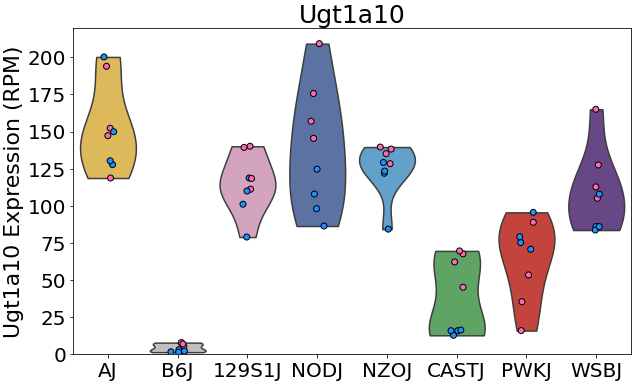

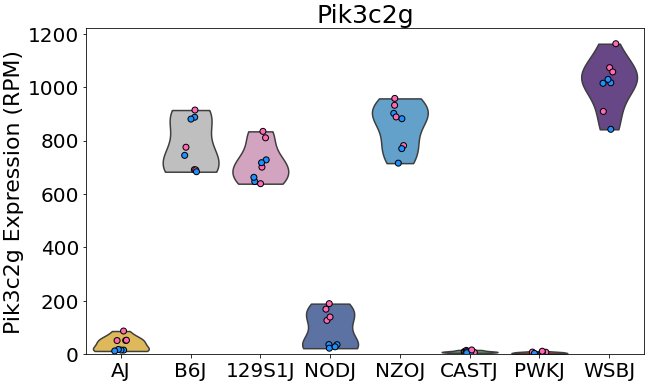

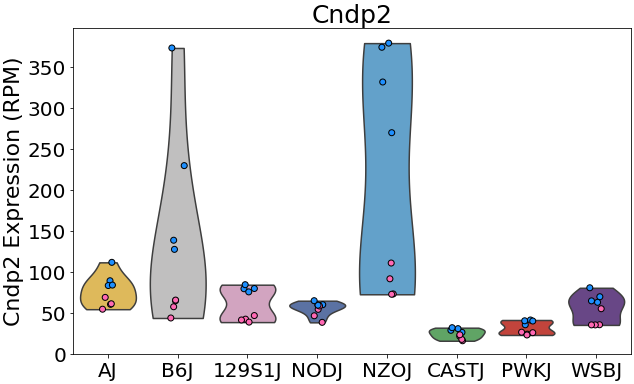

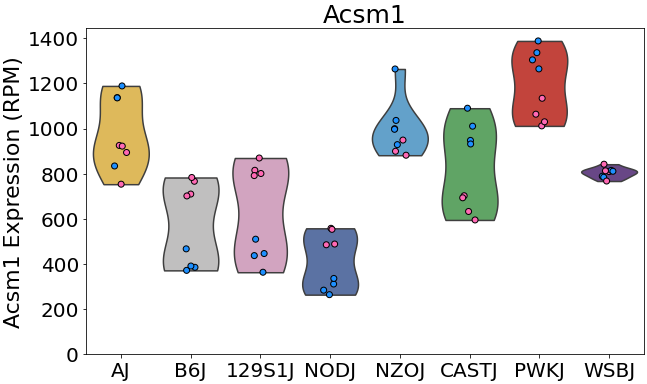

In [58]:
for gene in genes_of_interest:
    plot_gene(pbdata, gene)

In [59]:
def plot_zt_gene(dpadata, gene):
    plt.figure(figsize=(10, 6))
    
    pb_df = sc.get.obs_df(dpadata, ['ZT','Sex',gene])
    sns.violinplot(data=pb_df, x='ZT', y=gene, 
                   inner=None, cut=0, scale='width', 
                   legend=None)

    sns.stripplot(data=pb_df, x='ZT', y=gene, hue = 'Sex',
                  palette = sex_dict,
                  size=6, jitter=True,  
                  edgecolor='black', linewidth=1,
                  legend=None)


    plt.title(f'{gene}', fontsize=25)
    plt.xlabel('', fontsize=22)
    plt.ylabel(f'{gene} Expression (RPM)', fontsize=22)
    
    plt.xticks(fontsize=20, rotation=90, ha='right')
    plt.yticks(fontsize=20)
    plt.ylim(bottom=0)
    
    plt.show()

In [60]:
zt_order = sorted(pbdata.obs['ZT'].unique())
pbdata.obs['ZT'] = pd.Categorical(pbdata.obs['ZT'], categories=zt_order, ordered=True)


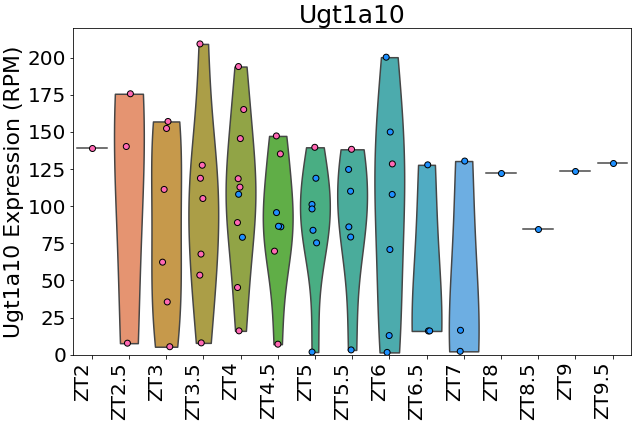

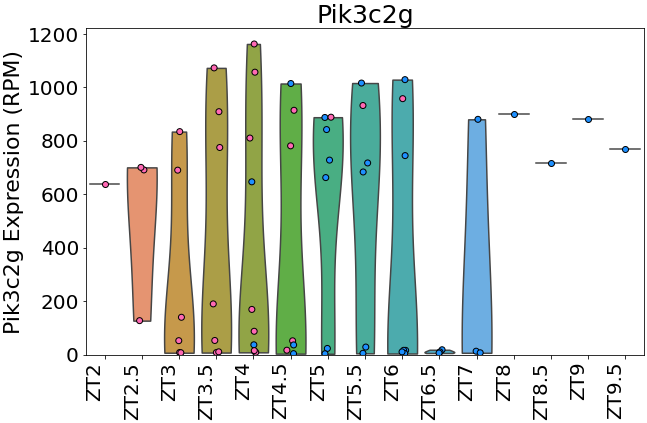

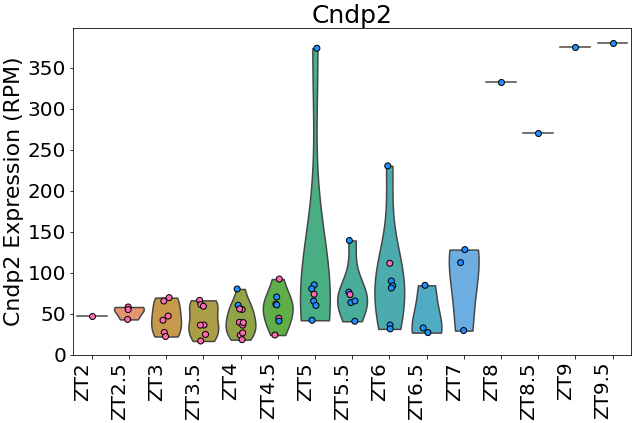

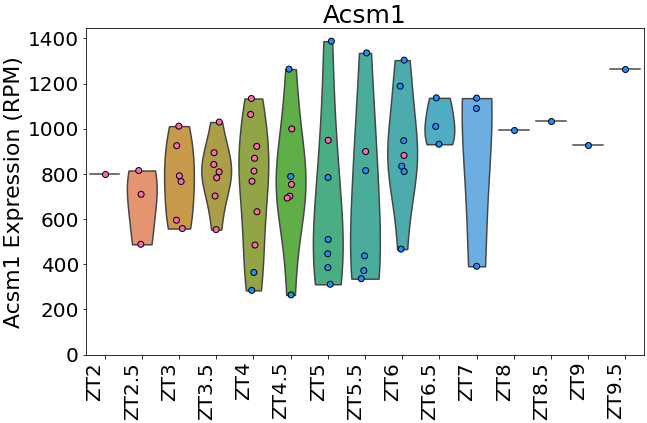

In [61]:
for gene in genes_of_interest:
    plot_zt_gene(pbdata, gene)